# 2D wave, direct problem
---
$$
\frac{\partial^2 u}{\partial t^2} - c^2\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) = 0.
$$

$$
c = 1.
$$

Initial condition:
$$
\frac{\partial u}{\partial t} = 0, \ u(x, y, 0) = \mathcal{N}(0, \sigma), \ \sigma = 5\times 10^{-4}.
$$

In [1]:
NAME = "0723_direct_problem"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [3]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c0, w0):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c0/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c0/m), m, n) for m, n, k in zip(layers[1:-1], layers[2:], keys[1:])]

layers = [3, 512, 512, 512, 512, 512, 1] # (x, y, t) -> p
c0 = 6.0
w0 = 30.0
direct_params = init_siren_params(random.PRNGKey(0), layers, c0, w0)

@jax.jit
def scalar_direct_model(params, x, y, t):
	x_ = jnp.hstack([x, y, t])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])

direct_model = jax.jit(jax.vmap(scalar_direct_model, in_axes = (None, 0, 0, 0)))
c = 1.0 # velocity

In [4]:
@jax.jit
def mae(pred, true):
	return jnp.mean(jnp.abs(pred - true))

@jax.jit
def scalar_du_dx(params, x, y, t):
    return jnp.sum(jax.grad(scalar_direct_model, 1)(params, x, y, t))

@jax.jit
def scalar_du_dy(params, x, y, t):
    return jnp.sum(jax.grad(scalar_direct_model, 2)(params, x, y, t))

@jax.jit
def scalar_du_dt(params, x, y, t):
    return jnp.sum(jax.grad(scalar_direct_model, 3)(params, x, y, t))

du_dt = jax.jit(jax.vmap(scalar_du_dt, (None, 0, 0, 0)))

@jax.jit
def du_dxx(params, x, y, t):
    return jax.grad(scalar_du_dx, 1)(params, x, y, t)

@jax.jit
def du_dyy(params, x, y, t):
    return jax.grad(scalar_du_dy, 2)(params, x, y, t)

@jax.jit
def du_dtt(params, x, y, t):
    return jax.grad(scalar_du_dt, 3)(params, x, y, t)

@jax.jit
def loss_fn_(params, batch):
	direct_params = params
	collocation, dirichlet, neumann = batch["collocation"], batch["dirichlet"], batch["neumann"]
	
	du_dtt_ = du_dtt(direct_params, collocation.x, collocation.y, collocation.t)
	du_dxx_ = du_dxx(direct_params, collocation.x, collocation.y, collocation.t)
	du_dyy_ = du_dyy(direct_params, collocation.x, collocation.y, collocation.t)
	
	u_pred = direct_model(direct_params, dirichlet.x, dirichlet.y, dirichlet.t).reshape((-1, 1))
	
	du_dt_ = du_dt(direct_params, neumann.x, neumann.y, neumann.t)
	
	loss_c = mae(du_dtt_ - c**2*(du_dxx_ + du_dyy_), 0)
	loss_d = mae(u_pred, dirichlet.u)
	loss_n = mae(du_dt_, neumann.g)
	return loss_c, loss_d, loss_n

@jax.jit
def loss_fn(params, batch):
	loss_c, loss_d, loss_n = loss_fn_(params, batch)
	weight = batch["weight"]
	return weight.c*loss_c + weight.d*loss_d + weight.n*loss_n

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	loss_c, loss_d, loss_n = loss_fn_(params, batch)
	return weight.c*loss_c + weight.d*loss_d + weight.n*loss_n, loss_c, loss_d, loss_n

In [5]:
dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "y", "t", "u"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "y", "t"])
dataset_Neumann = namedtuple("dataset_Neumann", ["x", "y", "t", "g"])
Weight = namedtuple("Weight", ["c", "d", "n"])

domain = np.array([-1, 1])
T_max = 0.4
sigma = 5e-4
source = np.array([0, 0])

np.random.seed(1)

# initial condition, source
N_source = 1000
r = 5e2*sigma*np.sqrt(np.random.random((N_source, 1)))
theta = 2*np.pi*np.random.random((N_source, 1))
x_source, y_source = r*np.cos(theta)+source[0], r*np.sin(theta)+source[1]
gaussian_2d = lambda x, y, mu, sigma: 1/np.sqrt(sigma**2*(2*np.pi)**2)*np.exp(-0.5*((x-mu[0])**2 + (y-mu[1])**2)/sigma)
f_source = lambda x, y: gaussian_2d(x, y, source, sigma) / (50*gaussian_2d(np.zeros((1, 1)), np.zeros((1, 1)), source, sigma))
u_source = f_source(x_source, y_source)
u_source[u_source < 1e-5] = 0.0
t_source = np.zeros_like(x_source)
g_source = np.zeros_like(x_source)
t_source_pretrain = transform(np.random.random((N_source, 1)), -0.001, 0.001)

# initial condition, general, for pretrain only
N_pretrain = 100000
x_pretrain = transform(np.random.random((N_pretrain, 1)), *domain)
y_pretrain = transform(np.random.random((N_pretrain, 1)), *domain)
t_pretrain = transform(np.random.random((N_pretrain, 1)), -0.001, 0.001)
u_pretrain = f_source(x_pretrain, y_pretrain)
u_pretrain[u_pretrain < 1e-5] = 0.0
g_pretrain = np.zeros_like(x_pretrain)

# initial condition, after pretrain
N_i = 1000
x_i = transform(np.random.random((N_i, 1)), *domain)
y_i = transform(np.random.random((N_i, 1)), *domain)
t_i = np.zeros_like(x_i)
u_i = f_source(x_i, y_i)
u_i[u_i < 1e-5] = 0.0
g_i = np.zeros_like(x_i)

# collocation points
N_c = 340
x_c = np.linspace(*domain, N_c)
y_c = np.linspace(*domain, N_c)
xy_c = tensor_grid([x_c, y_c])
t_c = np.zeros((xy_c.shape[0], 1))

class Batch_Generator:
	def __init__(self, dataset, batch_size):
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = np.arange(dataset[0].shape[0])
		np.random.shuffle(self.index)
		self.pointer = 0
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			np.random.shuffle(self.index)
			self.pointer = 0
		self.pointer += self.batch_size
		return [d[self.pointer-self.batch_size:self.pointer, :] for d in self.dataset]
	
map_jnp = lambda x: jnp.array(x, dtype = jnp.float32)

In [6]:
# Pretrain

Dirichlet_pretrain = dataset_Dirichlet(*map(map_jnp, [np.vstack([x_source, x_pretrain]), np.vstack([y_source, y_pretrain]), \
											 np.vstack([t_source_pretrain, t_pretrain]), np.vstack([u_source, u_pretrain])]))
Neumann_pretrain = dataset_Neumann(*map(map_jnp, [np.vstack([x_source, x_pretrain]), np.vstack([y_source, y_pretrain]), \
												  np.vstack([t_source_pretrain, t_pretrain]), np.vstack([g_source, g_pretrain])]))
Collocation_pretrain = dataset_Collocation(*map(map_jnp, [np.vstack([x_source, x_pretrain]), np.vstack([y_source, y_pretrain]), \
												  np.vstack([t_source_pretrain, t_pretrain])]))

lr = 2e-5
start_iteration = 1
iterations = 100000
print_every = 100
save_every = 10000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
batch_size_neumann = 10000
weight = Weight(1.0, 100.0, 10.0)

Collocation_pretrain_batched = Batch_Generator(Collocation_pretrain, batch_size_collocation)
Dirichlet_pretrain_batched = Batch_Generator(Dirichlet_pretrain, batch_size_dirichlet)
Neumann_pretrain_batched = Batch_Generator(Neumann_pretrain, batch_size_neumann)

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(direct_params)
for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet_pretrain_batched)),
		"collocation": dataset_Collocation(*next(Collocation_pretrain_batched)),
		"neumann": dataset_Neumann(*next(Neumann_pretrain_batched)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "neumann"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, direct_params_)

2020/07/23, 23:03:31, Iteration: 100, Train Loss: 1.4730e+03, collocation: 1.2838e+03, dirichlet: 3.3887e-01, neumann: 1.5536e+01
2020/07/23, 23:03:46, Iteration: 200, Train Loss: 7.6422e+02, collocation: 6.1338e+02, dirichlet: 2.7500e-01, neumann: 1.2333e+01
2020/07/23, 23:04:02, Iteration: 300, Train Loss: 5.0403e+02, collocation: 3.7946e+02, dirichlet: 2.3905e-01, neumann: 1.0066e+01
2020/07/23, 23:04:18, Iteration: 400, Train Loss: 3.7880e+02, collocation: 2.7467e+02, dirichlet: 2.1483e-01, neumann: 8.2646e+00
2020/07/23, 23:04:35, Iteration: 500, Train Loss: 3.0750e+02, collocation: 2.1620e+02, dirichlet: 1.9428e-01, neumann: 7.1872e+00
2020/07/23, 23:04:50, Iteration: 600, Train Loss: 2.5991e+02, collocation: 1.7799e+02, dirichlet: 1.8396e-01, neumann: 6.3518e+00
2020/07/23, 23:05:05, Iteration: 700, Train Loss: 2.2873e+02, collocation: 1.5657e+02, dirichlet: 1.6866e-01, neumann: 5.5292e+00
2020/07/23, 23:05:19, Iteration: 800, Train Loss: 2.0177e+02, collocation: 1.3610e+02, dir

2020/07/23, 23:15:54, Iteration: 6400, Train Loss: 3.6440e+01, collocation: 2.8012e+01, dirichlet: 2.3971e-02, neumann: 6.0303e-01
2020/07/23, 23:16:05, Iteration: 6500, Train Loss: 3.6409e+01, collocation: 2.8065e+01, dirichlet: 2.3750e-02, neumann: 5.9692e-01
2020/07/23, 23:16:16, Iteration: 6600, Train Loss: 3.6023e+01, collocation: 3.2938e+01, dirichlet: 1.6420e-02, neumann: 1.4429e-01
2020/07/23, 23:16:26, Iteration: 6700, Train Loss: 3.4418e+01, collocation: 2.6555e+01, dirichlet: 2.1961e-02, neumann: 5.6663e-01
2020/07/23, 23:16:37, Iteration: 6800, Train Loss: 3.4711e+01, collocation: 2.6849e+01, dirichlet: 2.2199e-02, neumann: 5.6413e-01
2020/07/23, 23:16:48, Iteration: 6900, Train Loss: 3.6089e+01, collocation: 2.8358e+01, dirichlet: 2.1720e-02, neumann: 5.5593e-01
2020/07/23, 23:16:59, Iteration: 7000, Train Loss: 3.5489e+01, collocation: 2.7833e+01, dirichlet: 2.1697e-02, neumann: 5.4864e-01
2020/07/23, 23:17:10, Iteration: 7100, Train Loss: 3.6357e+01, collocation: 2.8823e

2020/07/23, 23:27:21, Iteration: 12700, Train Loss: 2.5031e+01, collocation: 2.1132e+01, dirichlet: 1.0452e-02, neumann: 2.8538e-01
2020/07/23, 23:27:31, Iteration: 12800, Train Loss: 2.4995e+01, collocation: 2.1071e+01, dirichlet: 1.0457e-02, neumann: 2.8780e-01
2020/07/23, 23:27:42, Iteration: 12900, Train Loss: 2.4150e+01, collocation: 2.0258e+01, dirichlet: 1.0426e-02, neumann: 2.8494e-01
2020/07/23, 23:27:53, Iteration: 13000, Train Loss: 2.2919e+01, collocation: 1.9118e+01, dirichlet: 1.0254e-02, neumann: 2.7757e-01
2020/07/23, 23:28:04, Iteration: 13100, Train Loss: 2.2302e+01, collocation: 1.8522e+01, dirichlet: 1.0205e-02, neumann: 2.7592e-01
2020/07/23, 23:28:15, Iteration: 13200, Train Loss: 2.4338e+01, collocation: 2.2915e+01, dirichlet: 6.7048e-03, neumann: 7.5191e-02
2020/07/23, 23:28:25, Iteration: 13300, Train Loss: 2.2360e+01, collocation: 1.8702e+01, dirichlet: 9.5438e-03, neumann: 2.7038e-01
2020/07/23, 23:28:36, Iteration: 13400, Train Loss: 2.3293e+01, collocation:

2020/07/23, 23:38:40, Iteration: 19000, Train Loss: 1.9822e+01, collocation: 1.7366e+01, dirichlet: 6.3167e-03, neumann: 1.8238e-01
2020/07/23, 23:38:51, Iteration: 19100, Train Loss: 1.9783e+01, collocation: 1.7333e+01, dirichlet: 6.3994e-03, neumann: 1.8097e-01
2020/07/23, 23:39:02, Iteration: 19200, Train Loss: 2.0231e+01, collocation: 1.7812e+01, dirichlet: 6.1579e-03, neumann: 1.8038e-01
2020/07/23, 23:39:13, Iteration: 19300, Train Loss: 1.9991e+01, collocation: 1.7599e+01, dirichlet: 6.1726e-03, neumann: 1.7744e-01
2020/07/23, 23:39:24, Iteration: 19400, Train Loss: 1.9442e+01, collocation: 1.7028e+01, dirichlet: 6.2232e-03, neumann: 1.7913e-01
2020/07/23, 23:39:35, Iteration: 19500, Train Loss: 1.8512e+01, collocation: 1.6115e+01, dirichlet: 6.1842e-03, neumann: 1.7788e-01
2020/07/23, 23:39:46, Iteration: 19600, Train Loss: 1.7904e+01, collocation: 1.5524e+01, dirichlet: 6.1283e-03, neumann: 1.7669e-01
2020/07/23, 23:39:58, Iteration: 19700, Train Loss: 1.7202e+01, collocation:

2020/07/23, 23:50:15, Iteration: 25300, Train Loss: 1.7513e+01, collocation: 1.6751e+01, dirichlet: 2.7332e-03, neumann: 4.8851e-02
2020/07/23, 23:50:26, Iteration: 25400, Train Loss: 1.5135e+01, collocation: 1.3425e+01, dirichlet: 4.2454e-03, neumann: 1.2864e-01
2020/07/23, 23:50:37, Iteration: 25500, Train Loss: 1.5807e+01, collocation: 1.4081e+01, dirichlet: 4.3204e-03, neumann: 1.2938e-01
2020/07/23, 23:50:48, Iteration: 25600, Train Loss: 1.6279e+01, collocation: 1.4558e+01, dirichlet: 4.2290e-03, neumann: 1.2986e-01
2020/07/23, 23:50:58, Iteration: 25700, Train Loss: 1.6942e+01, collocation: 1.5219e+01, dirichlet: 4.3449e-03, neumann: 1.2893e-01
2020/07/23, 23:51:09, Iteration: 25800, Train Loss: 1.7016e+01, collocation: 1.5298e+01, dirichlet: 4.1883e-03, neumann: 1.2989e-01
2020/07/23, 23:51:21, Iteration: 25900, Train Loss: 1.6758e+01, collocation: 1.5088e+01, dirichlet: 4.1522e-03, neumann: 1.2551e-01
2020/07/23, 23:51:31, Iteration: 26000, Train Loss: 1.6396e+01, collocation:

2020/07/24, 00:01:38, Iteration: 31600, Train Loss: 1.3703e+01, collocation: 1.2393e+01, dirichlet: 3.1484e-03, neumann: 9.9520e-02
2020/07/24, 00:01:49, Iteration: 31700, Train Loss: 1.3009e+01, collocation: 1.1675e+01, dirichlet: 3.2136e-03, neumann: 1.0127e-01
2020/07/24, 00:02:00, Iteration: 31800, Train Loss: 1.2316e+01, collocation: 1.1031e+01, dirichlet: 3.1369e-03, neumann: 9.7114e-02
2020/07/24, 00:02:10, Iteration: 31900, Train Loss: 1.4821e+01, collocation: 1.4198e+01, dirichlet: 1.9458e-03, neumann: 4.2892e-02
2020/07/24, 00:02:21, Iteration: 32000, Train Loss: 1.2988e+01, collocation: 1.1687e+01, dirichlet: 3.0906e-03, neumann: 9.9191e-02
2020/07/24, 00:02:32, Iteration: 32100, Train Loss: 1.3854e+01, collocation: 1.2520e+01, dirichlet: 3.2250e-03, neumann: 1.0115e-01
2020/07/24, 00:02:43, Iteration: 32200, Train Loss: 1.4143e+01, collocation: 1.2858e+01, dirichlet: 3.0509e-03, neumann: 9.7954e-02
2020/07/24, 00:02:54, Iteration: 32300, Train Loss: 1.4144e+01, collocation:

2020/07/24, 00:13:02, Iteration: 37900, Train Loss: 1.3147e+01, collocation: 1.2092e+01, dirichlet: 2.4665e-03, neumann: 8.0834e-02
2020/07/24, 00:13:13, Iteration: 38000, Train Loss: 1.2456e+01, collocation: 1.1430e+01, dirichlet: 2.3889e-03, neumann: 7.8658e-02
2020/07/24, 00:13:23, Iteration: 38100, Train Loss: 1.2398e+01, collocation: 1.1365e+01, dirichlet: 2.4486e-03, neumann: 7.8812e-02
2020/07/24, 00:13:34, Iteration: 38200, Train Loss: 1.1726e+01, collocation: 1.0698e+01, dirichlet: 2.4082e-03, neumann: 7.8691e-02
2020/07/24, 00:13:45, Iteration: 38300, Train Loss: 1.1344e+01, collocation: 1.0308e+01, dirichlet: 2.4146e-03, neumann: 7.9432e-02
2020/07/24, 00:13:56, Iteration: 38400, Train Loss: 1.0649e+01, collocation: 9.6568e+00, dirichlet: 2.3580e-03, neumann: 7.5636e-02
2020/07/24, 00:14:07, Iteration: 38500, Train Loss: 1.2358e+01, collocation: 1.1789e+01, dirichlet: 1.6506e-03, neumann: 4.0414e-02
2020/07/24, 00:14:18, Iteration: 38600, Train Loss: 1.1406e+01, collocation:

2020/07/24, 00:24:27, Iteration: 44200, Train Loss: 1.0791e+01, collocation: 9.9183e+00, dirichlet: 2.0378e-03, neumann: 6.6881e-02
2020/07/24, 00:24:38, Iteration: 44300, Train Loss: 1.1075e+01, collocation: 1.0204e+01, dirichlet: 1.9774e-03, neumann: 6.7273e-02
2020/07/24, 00:24:49, Iteration: 44400, Train Loss: 1.1104e+01, collocation: 1.0230e+01, dirichlet: 2.0498e-03, neumann: 6.6907e-02
2020/07/24, 00:24:59, Iteration: 44500, Train Loss: 1.1482e+01, collocation: 1.0607e+01, dirichlet: 2.0257e-03, neumann: 6.7260e-02
2020/07/24, 00:25:10, Iteration: 44600, Train Loss: 1.0957e+01, collocation: 1.0116e+01, dirichlet: 1.9411e-03, neumann: 6.4735e-02
2020/07/24, 00:25:21, Iteration: 44700, Train Loss: 1.0890e+01, collocation: 1.0035e+01, dirichlet: 1.9921e-03, neumann: 6.5571e-02
2020/07/24, 00:25:33, Iteration: 44800, Train Loss: 1.0306e+01, collocation: 9.4637e+00, dirichlet: 1.9177e-03, neumann: 6.5035e-02
2020/07/24, 00:25:44, Iteration: 44900, Train Loss: 9.9536e+00, collocation:

2020/07/24, 00:35:55, Iteration: 50500, Train Loss: 8.3351e+00, collocation: 7.6306e+00, dirichlet: 1.5990e-03, neumann: 5.4460e-02
2020/07/24, 00:36:06, Iteration: 50600, Train Loss: 9.5966e+00, collocation: 9.1413e+00, dirichlet: 1.2513e-03, neumann: 3.3017e-02
2020/07/24, 00:36:17, Iteration: 50700, Train Loss: 9.0155e+00, collocation: 8.2786e+00, dirichlet: 1.6857e-03, neumann: 5.6832e-02
2020/07/24, 00:36:28, Iteration: 50800, Train Loss: 9.3500e+00, collocation: 8.6177e+00, dirichlet: 1.6968e-03, neumann: 5.6255e-02
2020/07/24, 00:36:39, Iteration: 50900, Train Loss: 9.7519e+00, collocation: 9.0062e+00, dirichlet: 1.6599e-03, neumann: 5.7963e-02
2020/07/24, 00:36:50, Iteration: 51000, Train Loss: 1.0165e+01, collocation: 9.4454e+00, dirichlet: 1.7029e-03, neumann: 5.4969e-02
2020/07/24, 00:37:01, Iteration: 51100, Train Loss: 1.0088e+01, collocation: 9.3586e+00, dirichlet: 1.6350e-03, neumann: 5.6571e-02
2020/07/24, 00:37:12, Iteration: 51200, Train Loss: 9.5994e+00, collocation:

2020/07/24, 00:47:24, Iteration: 56800, Train Loss: 8.4105e+00, collocation: 7.7960e+00, dirichlet: 1.3876e-03, neumann: 4.7576e-02
2020/07/24, 00:47:35, Iteration: 56900, Train Loss: 8.0787e+00, collocation: 7.4564e+00, dirichlet: 1.3710e-03, neumann: 4.8526e-02
2020/07/24, 00:47:46, Iteration: 57000, Train Loss: 7.7696e+00, collocation: 7.1692e+00, dirichlet: 1.3457e-03, neumann: 4.6587e-02
2020/07/24, 00:47:57, Iteration: 57100, Train Loss: 7.3424e+00, collocation: 6.7550e+00, dirichlet: 1.3366e-03, neumann: 4.5376e-02
2020/07/24, 00:48:08, Iteration: 57200, Train Loss: 8.3938e+00, collocation: 7.9789e+00, dirichlet: 1.0060e-03, neumann: 3.1440e-02
2020/07/24, 00:48:19, Iteration: 57300, Train Loss: 7.7869e+00, collocation: 7.1686e+00, dirichlet: 1.3847e-03, neumann: 4.7984e-02
2020/07/24, 00:48:30, Iteration: 57400, Train Loss: 8.4860e+00, collocation: 7.8517e+00, dirichlet: 1.4107e-03, neumann: 4.9320e-02
2020/07/24, 00:48:41, Iteration: 57500, Train Loss: 8.7347e+00, collocation:

2020/07/24, 00:58:46, Iteration: 63100, Train Loss: 7.9307e+00, collocation: 7.3817e+00, dirichlet: 1.2387e-03, neumann: 4.2517e-02
2020/07/24, 00:58:56, Iteration: 63200, Train Loss: 7.8495e+00, collocation: 7.3069e+00, dirichlet: 1.1845e-03, neumann: 4.2410e-02
2020/07/24, 00:59:07, Iteration: 63300, Train Loss: 7.8784e+00, collocation: 7.3481e+00, dirichlet: 1.1771e-03, neumann: 4.1260e-02
2020/07/24, 00:59:17, Iteration: 63400, Train Loss: 7.3916e+00, collocation: 6.8640e+00, dirichlet: 1.1760e-03, neumann: 4.0999e-02
2020/07/24, 00:59:28, Iteration: 63500, Train Loss: 7.1369e+00, collocation: 6.6137e+00, dirichlet: 1.1537e-03, neumann: 4.0782e-02
2020/07/24, 00:59:38, Iteration: 63600, Train Loss: 6.8698e+00, collocation: 6.3527e+00, dirichlet: 1.1400e-03, neumann: 4.0315e-02
2020/07/24, 00:59:49, Iteration: 63700, Train Loss: 6.5377e+00, collocation: 6.0209e+00, dirichlet: 1.1517e-03, neumann: 4.0158e-02
2020/07/24, 00:59:59, Iteration: 63800, Train Loss: 7.0995e+00, collocation:

2020/07/24, 01:10:07, Iteration: 69400, Train Loss: 6.4362e+00, collocation: 5.9362e+00, dirichlet: 1.1554e-03, neumann: 3.8446e-02
2020/07/24, 01:10:18, Iteration: 69500, Train Loss: 6.6917e+00, collocation: 6.2093e+00, dirichlet: 1.1069e-03, neumann: 3.7177e-02
2020/07/24, 01:10:29, Iteration: 69600, Train Loss: 7.0411e+00, collocation: 6.5389e+00, dirichlet: 1.1070e-03, neumann: 3.9152e-02
2020/07/24, 01:10:41, Iteration: 69700, Train Loss: 6.9632e+00, collocation: 6.4960e+00, dirichlet: 1.0456e-03, neumann: 3.6257e-02
2020/07/24, 01:10:52, Iteration: 69800, Train Loss: 7.0128e+00, collocation: 6.5322e+00, dirichlet: 1.0738e-03, neumann: 3.7330e-02
2020/07/24, 01:11:03, Iteration: 69900, Train Loss: 6.8202e+00, collocation: 6.3548e+00, dirichlet: 1.0353e-03, neumann: 3.6188e-02
2020/07/24, 01:11:14, Iteration: 70000, Train Loss: 6.6543e+00, collocation: 6.1930e+00, dirichlet: 1.0198e-03, neumann: 3.5935e-02
2020/07/24, 01:11:25, Iteration: 70100, Train Loss: 6.2067e+00, collocation:

2020/07/24, 01:21:44, Iteration: 75700, Train Loss: 5.4799e+00, collocation: 5.0729e+00, dirichlet: 8.9265e-04, neumann: 3.1772e-02
2020/07/24, 01:21:55, Iteration: 75800, Train Loss: 5.1120e+00, collocation: 4.7210e+00, dirichlet: 8.6328e-04, neumann: 3.0466e-02
2020/07/24, 01:22:06, Iteration: 75900, Train Loss: 5.4978e+00, collocation: 5.1798e+00, dirichlet: 8.0759e-04, neumann: 2.3722e-02
2020/07/24, 01:22:17, Iteration: 76000, Train Loss: 5.6720e+00, collocation: 5.2345e+00, dirichlet: 9.9438e-04, neumann: 3.3807e-02
2020/07/24, 01:22:28, Iteration: 76100, Train Loss: 5.9008e+00, collocation: 5.4779e+00, dirichlet: 9.3884e-04, neumann: 3.2899e-02
2020/07/24, 01:22:40, Iteration: 76200, Train Loss: 6.1829e+00, collocation: 5.7672e+00, dirichlet: 8.9936e-04, neumann: 3.2573e-02
2020/07/24, 01:22:51, Iteration: 76300, Train Loss: 6.1984e+00, collocation: 5.7706e+00, dirichlet: 9.6360e-04, neumann: 3.3144e-02
2020/07/24, 01:23:02, Iteration: 76400, Train Loss: 6.1494e+00, collocation:

2020/07/24, 01:33:30, Iteration: 82000, Train Loss: 5.5693e+00, collocation: 5.2051e+00, dirichlet: 7.9018e-04, neumann: 2.8520e-02
2020/07/24, 01:33:41, Iteration: 82100, Train Loss: 5.3996e+00, collocation: 5.0349e+00, dirichlet: 8.0733e-04, neumann: 2.8400e-02
2020/07/24, 01:33:52, Iteration: 82200, Train Loss: 5.1284e+00, collocation: 4.7646e+00, dirichlet: 8.5781e-04, neumann: 2.7809e-02
2020/07/24, 01:34:03, Iteration: 82300, Train Loss: 4.9705e+00, collocation: 4.6179e+00, dirichlet: 7.7882e-04, neumann: 2.7478e-02
2020/07/24, 01:34:13, Iteration: 82400, Train Loss: 4.6185e+00, collocation: 4.2508e+00, dirichlet: 8.7115e-04, neumann: 2.8054e-02
2020/07/24, 01:34:24, Iteration: 82500, Train Loss: 5.0869e+00, collocation: 4.7691e+00, dirichlet: 7.9397e-04, neumann: 2.3841e-02
2020/07/24, 01:34:35, Iteration: 82600, Train Loss: 5.0849e+00, collocation: 4.6871e+00, dirichlet: 9.0333e-04, neumann: 3.0751e-02
2020/07/24, 01:34:46, Iteration: 82700, Train Loss: 5.3635e+00, collocation:

2020/07/24, 01:45:11, Iteration: 88300, Train Loss: 4.9817e+00, collocation: 4.6379e+00, dirichlet: 7.7446e-04, neumann: 2.6641e-02
2020/07/24, 01:45:22, Iteration: 88400, Train Loss: 5.0632e+00, collocation: 4.7146e+00, dirichlet: 7.6110e-04, neumann: 2.7246e-02
2020/07/24, 01:45:33, Iteration: 88500, Train Loss: 4.9062e+00, collocation: 4.5719e+00, dirichlet: 7.3660e-04, neumann: 2.6068e-02
2020/07/24, 01:45:44, Iteration: 88600, Train Loss: 4.8969e+00, collocation: 4.5747e+00, dirichlet: 7.0228e-04, neumann: 2.5196e-02
2020/07/24, 01:45:55, Iteration: 88700, Train Loss: 4.6033e+00, collocation: 4.2799e+00, dirichlet: 7.3027e-04, neumann: 2.5043e-02
2020/07/24, 01:46:07, Iteration: 88800, Train Loss: 4.5395e+00, collocation: 4.2158e+00, dirichlet: 7.0878e-04, neumann: 2.5284e-02
2020/07/24, 01:46:18, Iteration: 88900, Train Loss: 4.3750e+00, collocation: 4.0415e+00, dirichlet: 7.5345e-04, neumann: 2.5818e-02
2020/07/24, 01:46:29, Iteration: 89000, Train Loss: 4.0378e+00, collocation:

2020/07/24, 01:56:53, Iteration: 94600, Train Loss: 4.0349e+00, collocation: 3.7847e+00, dirichlet: 6.1593e-04, neumann: 1.8857e-02
2020/07/24, 01:57:04, Iteration: 94700, Train Loss: 4.1360e+00, collocation: 3.8092e+00, dirichlet: 7.5991e-04, neumann: 2.5083e-02
2020/07/24, 01:57:15, Iteration: 94800, Train Loss: 4.4327e+00, collocation: 4.1168e+00, dirichlet: 6.9477e-04, neumann: 2.4644e-02
2020/07/24, 01:57:26, Iteration: 94900, Train Loss: 4.3980e+00, collocation: 4.0840e+00, dirichlet: 6.8677e-04, neumann: 2.4535e-02
2020/07/24, 01:57:37, Iteration: 95000, Train Loss: 4.6070e+00, collocation: 4.2882e+00, dirichlet: 7.4445e-04, neumann: 2.4435e-02
2020/07/24, 01:57:48, Iteration: 95100, Train Loss: 4.4193e+00, collocation: 4.1301e+00, dirichlet: 6.5153e-04, neumann: 2.2400e-02
2020/07/24, 01:58:00, Iteration: 95200, Train Loss: 4.4919e+00, collocation: 4.1940e+00, dirichlet: 6.7186e-04, neumann: 2.3073e-02
2020/07/24, 01:58:11, Iteration: 95300, Train Loss: 4.3186e+00, collocation:

In [7]:
# pretrain, cont.

start_iteration = 100001
iterations = 200000
print_every = 500
save_every = 10000

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet_pretrain_batched)),
		"collocation": dataset_Collocation(*next(Collocation_pretrain_batched)),
		"neumann": dataset_Neumann(*next(Neumann_pretrain_batched)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "neumann"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, direct_params_)

2020/07/24, 02:07:50, Iteration: 100500, Train Loss: 4.1208e+00, collocation: 3.8483e+00, dirichlet: 6.0665e-04, neumann: 2.1191e-02
2020/07/24, 02:08:45, Iteration: 101000, Train Loss: 3.3614e+00, collocation: 3.1136e+00, dirichlet: 5.5980e-04, neumann: 1.9189e-02
2020/07/24, 02:09:41, Iteration: 101500, Train Loss: 4.0501e+00, collocation: 3.7850e+00, dirichlet: 6.1059e-04, neumann: 2.0412e-02
2020/07/24, 02:10:37, Iteration: 102000, Train Loss: 3.3885e+00, collocation: 3.1439e+00, dirichlet: 5.6316e-04, neumann: 1.8831e-02
2020/07/24, 02:11:33, Iteration: 102500, Train Loss: 3.9799e+00, collocation: 3.6993e+00, dirichlet: 6.3988e-04, neumann: 2.1659e-02
2020/07/24, 02:12:28, Iteration: 103000, Train Loss: 3.5074e+00, collocation: 3.2613e+00, dirichlet: 5.4874e-04, neumann: 1.9116e-02
2020/07/24, 02:13:24, Iteration: 103500, Train Loss: 3.6373e+00, collocation: 3.3766e+00, dirichlet: 5.8448e-04, neumann: 2.0230e-02
2020/07/24, 02:14:20, Iteration: 104000, Train Loss: 3.6065e+00, coll

2020/07/24, 03:05:27, Iteration: 131500, Train Loss: 2.2713e+00, collocation: 2.1068e+00, dirichlet: 3.7699e-04, neumann: 1.2681e-02
2020/07/24, 03:06:23, Iteration: 132000, Train Loss: 2.2737e+00, collocation: 2.0805e+00, dirichlet: 4.7957e-04, neumann: 1.4522e-02
2020/07/24, 03:07:19, Iteration: 132500, Train Loss: 2.2729e+00, collocation: 2.1045e+00, dirichlet: 3.8062e-04, neumann: 1.3032e-02
2020/07/24, 03:08:15, Iteration: 133000, Train Loss: 2.0896e+00, collocation: 1.9209e+00, dirichlet: 4.2972e-04, neumann: 1.2577e-02
2020/07/24, 03:09:11, Iteration: 133500, Train Loss: 2.3789e+00, collocation: 2.1914e+00, dirichlet: 4.5752e-04, neumann: 1.4178e-02
2020/07/24, 03:10:07, Iteration: 134000, Train Loss: 1.8808e+00, collocation: 1.7339e+00, dirichlet: 3.6526e-04, neumann: 1.1035e-02
2020/07/24, 03:11:03, Iteration: 134500, Train Loss: 2.2955e+00, collocation: 2.1301e+00, dirichlet: 3.9018e-04, neumann: 1.2634e-02
2020/07/24, 03:11:58, Iteration: 135000, Train Loss: 1.9640e+00, coll

2020/07/24, 04:03:08, Iteration: 162500, Train Loss: 1.2600e+00, collocation: 1.1511e+00, dirichlet: 2.7203e-04, neumann: 8.1697e-03
2020/07/24, 04:04:04, Iteration: 163000, Train Loss: 1.4893e+00, collocation: 1.3583e+00, dirichlet: 3.3307e-04, neumann: 9.7645e-03
2020/07/24, 04:04:59, Iteration: 163500, Train Loss: 1.3242e+00, collocation: 1.2061e+00, dirichlet: 3.0460e-04, neumann: 8.7595e-03
2020/07/24, 04:05:55, Iteration: 164000, Train Loss: 1.4029e+00, collocation: 1.2831e+00, dirichlet: 2.8839e-04, neumann: 9.0924e-03
2020/07/24, 04:06:51, Iteration: 164500, Train Loss: 1.3356e+00, collocation: 1.2259e+00, dirichlet: 2.6838e-04, neumann: 8.2844e-03
2020/07/24, 04:07:47, Iteration: 165000, Train Loss: 1.3401e+00, collocation: 1.2057e+00, dirichlet: 3.7013e-04, neumann: 9.7416e-03
2020/07/24, 04:08:43, Iteration: 165500, Train Loss: 1.3469e+00, collocation: 1.2313e+00, dirichlet: 2.8389e-04, neumann: 8.7166e-03
2020/07/24, 04:09:38, Iteration: 166000, Train Loss: 1.1905e+00, coll

2020/07/24, 05:00:31, Iteration: 193500, Train Loss: 8.1763e-01, collocation: 7.2856e-01, dirichlet: 2.5855e-04, neumann: 6.3219e-03
2020/07/24, 05:01:27, Iteration: 194000, Train Loss: 8.4398e-01, collocation: 7.6727e-01, dirichlet: 1.9900e-04, neumann: 5.6811e-03
2020/07/24, 05:02:23, Iteration: 194500, Train Loss: 7.0894e-01, collocation: 6.4089e-01, dirichlet: 1.7801e-04, neumann: 5.0244e-03
2020/07/24, 05:03:19, Iteration: 195000, Train Loss: 8.9950e-01, collocation: 8.0954e-01, dirichlet: 2.4161e-04, neumann: 6.5793e-03
2020/07/24, 05:04:15, Iteration: 195500, Train Loss: 7.6057e-01, collocation: 6.8589e-01, dirichlet: 1.9014e-04, neumann: 5.5668e-03
2020/07/24, 05:05:10, Iteration: 196000, Train Loss: 8.8742e-01, collocation: 7.9369e-01, dirichlet: 2.4772e-04, neumann: 6.8962e-03
2020/07/24, 05:06:06, Iteration: 196500, Train Loss: 7.9934e-01, collocation: 7.2193e-01, dirichlet: 2.1324e-04, neumann: 5.6085e-03
2020/07/24, 05:07:02, Iteration: 197000, Train Loss: 8.4337e-01, coll

2020/07/24, 05:58:08, Iteration: 224500, Train Loss: 6.0795e-01, collocation: 5.3769e-01, dirichlet: 1.9323e-04, neumann: 5.0938e-03
2020/07/24, 05:59:03, Iteration: 225000, Train Loss: 5.4609e-01, collocation: 4.8567e-01, dirichlet: 1.6279e-04, neumann: 4.4143e-03
2020/07/24, 05:59:59, Iteration: 225500, Train Loss: 5.9032e-01, collocation: 5.1533e-01, dirichlet: 2.3186e-04, neumann: 5.1807e-03
2020/07/24, 06:00:55, Iteration: 226000, Train Loss: 5.4185e-01, collocation: 4.8126e-01, dirichlet: 1.5603e-04, neumann: 4.4984e-03
2020/07/24, 06:01:52, Iteration: 226500, Train Loss: 5.4855e-01, collocation: 4.7657e-01, dirichlet: 2.3042e-04, neumann: 4.8941e-03
2020/07/24, 06:02:48, Iteration: 227000, Train Loss: 5.4770e-01, collocation: 4.8583e-01, dirichlet: 1.6722e-04, neumann: 4.5148e-03
2020/07/24, 06:03:45, Iteration: 227500, Train Loss: 4.7794e-01, collocation: 4.1920e-01, dirichlet: 1.7047e-04, neumann: 4.1703e-03
2020/07/24, 06:04:40, Iteration: 228000, Train Loss: 5.7648e-01, coll

2020/07/24, 06:54:34, Iteration: 255500, Train Loss: 3.6753e-01, collocation: 3.2340e-01, dirichlet: 1.2651e-04, neumann: 3.1486e-03
2020/07/24, 06:55:27, Iteration: 256000, Train Loss: 3.4336e-01, collocation: 2.9825e-01, dirichlet: 1.3510e-04, neumann: 3.1600e-03
2020/07/24, 06:56:21, Iteration: 256500, Train Loss: 3.8318e-01, collocation: 3.3199e-01, dirichlet: 1.4700e-04, neumann: 3.6496e-03
2020/07/24, 06:57:15, Iteration: 257000, Train Loss: 3.4582e-01, collocation: 3.0236e-01, dirichlet: 1.3216e-04, neumann: 3.0247e-03
2020/07/24, 06:58:10, Iteration: 257500, Train Loss: 3.7140e-01, collocation: 3.1804e-01, dirichlet: 1.5875e-04, neumann: 3.7489e-03
2020/07/24, 06:59:04, Iteration: 258000, Train Loss: 3.5524e-01, collocation: 3.0863e-01, dirichlet: 1.3695e-04, neumann: 3.2914e-03
2020/07/24, 06:59:59, Iteration: 258500, Train Loss: 3.9961e-01, collocation: 3.4080e-01, dirichlet: 2.0403e-04, neumann: 3.8412e-03
2020/07/24, 07:00:54, Iteration: 259000, Train Loss: 3.5175e-01, coll

2020/07/24, 07:50:41, Iteration: 286500, Train Loss: 2.3809e-01, collocation: 2.0187e-01, dirichlet: 1.1250e-04, neumann: 2.4978e-03
2020/07/24, 07:51:35, Iteration: 287000, Train Loss: 2.5770e-01, collocation: 2.0944e-01, dirichlet: 1.6353e-04, neumann: 3.1911e-03
2020/07/24, 07:52:28, Iteration: 287500, Train Loss: 2.4330e-01, collocation: 2.0704e-01, dirichlet: 1.0666e-04, neumann: 2.5593e-03
2020/07/24, 07:53:23, Iteration: 288000, Train Loss: 2.1483e-01, collocation: 1.8210e-01, dirichlet: 1.1363e-04, neumann: 2.1364e-03
2020/07/24, 07:54:16, Iteration: 288500, Train Loss: 2.3137e-01, collocation: 1.9560e-01, dirichlet: 1.1233e-04, neumann: 2.4531e-03
2020/07/24, 07:55:10, Iteration: 289000, Train Loss: 2.3359e-01, collocation: 1.9819e-01, dirichlet: 1.2155e-04, neumann: 2.3243e-03
2020/07/24, 07:56:03, Iteration: 289500, Train Loss: 2.4934e-01, collocation: 2.1187e-01, dirichlet: 1.1692e-04, neumann: 2.5774e-03
2020/07/24, 07:56:57, Iteration: 290000, Train Loss: 2.1643e-01, coll

In [8]:
# pretrain, cont;

start_iteration = 300001
iterations = 50000
print_every = 500
save_every = 10000

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet_pretrain_batched)),
		"collocation": dataset_Collocation(*next(Collocation_pretrain_batched)),
		"neumann": dataset_Neumann(*next(Neumann_pretrain_batched)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "neumann"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, direct_params_)

2020/07/24, 08:16:00, Iteration: 300500, Train Loss: 2.0415e-01, collocation: 1.7119e-01, dirichlet: 1.0738e-04, neumann: 2.2223e-03
2020/07/24, 08:16:55, Iteration: 301000, Train Loss: 1.7953e-01, collocation: 1.5095e-01, dirichlet: 9.6800e-05, neumann: 1.8901e-03
2020/07/24, 08:17:49, Iteration: 301500, Train Loss: 1.9987e-01, collocation: 1.6700e-01, dirichlet: 9.8295e-05, neumann: 2.3040e-03
2020/07/24, 08:18:44, Iteration: 302000, Train Loss: 1.7828e-01, collocation: 1.5021e-01, dirichlet: 9.2690e-05, neumann: 1.8801e-03
2020/07/24, 08:19:39, Iteration: 302500, Train Loss: 1.9478e-01, collocation: 1.6033e-01, dirichlet: 1.1724e-04, neumann: 2.2720e-03
2020/07/24, 08:20:34, Iteration: 303000, Train Loss: 1.8178e-01, collocation: 1.5197e-01, dirichlet: 9.3990e-05, neumann: 2.0412e-03
2020/07/24, 08:21:28, Iteration: 303500, Train Loss: 2.1265e-01, collocation: 1.7445e-01, dirichlet: 1.4279e-04, neumann: 2.3917e-03
2020/07/24, 08:22:23, Iteration: 304000, Train Loss: 1.8444e-01, coll

2020/07/24, 09:11:26, Iteration: 331500, Train Loss: 1.1897e-01, collocation: 9.5078e-02, dirichlet: 8.4007e-05, neumann: 1.5493e-03
2020/07/24, 09:12:20, Iteration: 332000, Train Loss: 1.4468e-01, collocation: 1.1474e-01, dirichlet: 1.2103e-04, neumann: 1.7834e-03
2020/07/24, 09:13:15, Iteration: 332500, Train Loss: 1.1983e-01, collocation: 9.8441e-02, dirichlet: 7.0971e-05, neumann: 1.4288e-03
2020/07/24, 09:14:10, Iteration: 333000, Train Loss: 1.1131e-01, collocation: 8.8158e-02, dirichlet: 8.7840e-05, neumann: 1.4363e-03
2020/07/24, 09:15:04, Iteration: 333500, Train Loss: 1.1212e-01, collocation: 9.1220e-02, dirichlet: 7.1802e-05, neumann: 1.3722e-03
2020/07/24, 09:15:59, Iteration: 334000, Train Loss: 1.1242e-01, collocation: 9.1303e-02, dirichlet: 7.7038e-05, neumann: 1.3418e-03
2020/07/24, 09:16:54, Iteration: 334500, Train Loss: 1.1622e-01, collocation: 9.3700e-02, dirichlet: 7.9326e-05, neumann: 1.4583e-03
2020/07/24, 09:17:49, Iteration: 335000, Train Loss: 1.0394e-01, coll

In [9]:
# pretrain, cont;

start_iteration = 350001
iterations = 50000
print_every = 500
save_every = 10000

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet_pretrain_batched)),
		"collocation": dataset_Collocation(*next(Collocation_pretrain_batched)),
		"neumann": dataset_Neumann(*next(Neumann_pretrain_batched)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "neumann"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, direct_params_)

2020/07/24, 09:49:27, Iteration: 350500, Train Loss: 7.4282e-02, collocation: 5.8208e-02, dirichlet: 6.4816e-05, neumann: 9.5931e-04
2020/07/24, 09:50:42, Iteration: 351000, Train Loss: 8.4879e-02, collocation: 6.6326e-02, dirichlet: 7.0160e-05, neumann: 1.1536e-03
2020/07/24, 09:51:53, Iteration: 351500, Train Loss: 8.1714e-02, collocation: 6.3267e-02, dirichlet: 6.7929e-05, neumann: 1.1654e-03
2020/07/24, 09:52:59, Iteration: 352000, Train Loss: 8.5544e-02, collocation: 6.6185e-02, dirichlet: 7.1245e-05, neumann: 1.2235e-03
2020/07/24, 09:54:00, Iteration: 352500, Train Loss: 7.8944e-02, collocation: 6.2333e-02, dirichlet: 6.4836e-05, neumann: 1.0128e-03
2020/07/24, 09:54:57, Iteration: 353000, Train Loss: 8.1663e-02, collocation: 6.4047e-02, dirichlet: 6.3486e-05, neumann: 1.1268e-03
2020/07/24, 09:55:51, Iteration: 353500, Train Loss: 7.7695e-02, collocation: 6.2143e-02, dirichlet: 5.6044e-05, neumann: 9.9475e-04
2020/07/24, 09:56:45, Iteration: 354000, Train Loss: 8.3546e-02, coll

2020/07/24, 10:46:41, Iteration: 381500, Train Loss: 4.9994e-02, collocation: 3.4218e-02, dirichlet: 8.3939e-05, neumann: 7.3816e-04
2020/07/24, 10:47:36, Iteration: 382000, Train Loss: 4.1358e-02, collocation: 3.0265e-02, dirichlet: 4.4326e-05, neumann: 6.6607e-04
2020/07/24, 10:48:29, Iteration: 382500, Train Loss: 4.8002e-02, collocation: 3.3894e-02, dirichlet: 6.9787e-05, neumann: 7.1297e-04
2020/07/24, 10:49:22, Iteration: 383000, Train Loss: 3.7513e-02, collocation: 2.7617e-02, dirichlet: 4.0472e-05, neumann: 5.8495e-04
2020/07/24, 10:50:14, Iteration: 383500, Train Loss: 3.9082e-02, collocation: 2.7930e-02, dirichlet: 5.0671e-05, neumann: 6.0845e-04
2020/07/24, 10:51:07, Iteration: 384000, Train Loss: 4.1558e-02, collocation: 3.0074e-02, dirichlet: 4.8584e-05, neumann: 6.6260e-04
2020/07/24, 10:52:01, Iteration: 384500, Train Loss: 3.7482e-02, collocation: 2.7921e-02, dirichlet: 3.7893e-05, neumann: 5.7721e-04
2020/07/24, 10:52:55, Iteration: 385000, Train Loss: 3.9298e-02, coll

In [16]:
# After pretrain

Dirichlet = dataset_Dirichlet(*map(map_jnp, [np.vstack([x_source, x_i]), np.vstack([y_source, y_i]), \
											 np.vstack([t_source, t_i]), np.vstack([u_source, u_i])]))
Neumann = dataset_Neumann(*map(map_jnp, [np.vstack([x_source, x_i]), np.vstack([y_source, y_i]), \
										np.vstack([t_source, t_i]), np.vstack([g_source, g_i])]))
Collocation_i = dataset_Collocation(np.vstack([x_source, x_i]), np.vstack([y_source, y_i]), np.vstack([t_source, t_i]))
Collocation_c = dataset_Collocation(xy_c[:, 0:1], xy_c[:, 1:2], t_c)

lr = 2e-5
start_iteration = 400001
iterations = 1000000
print_every = 500
save_every = 10000
batch_size_collocation_i = 1000
batch_size_collocation_c = 10000
batch_size_dirichlet = 10000
batch_size_neumann = 1000
weight = Weight(1.0, 100.0, 10.0)

Collocation_i_batched = Batch_Generator(Collocation_i, batch_size_collocation_i)
Collocation_c_batched = Batch_Generator(Collocation_c, batch_size_collocation_c)
Dirichlet_batched = Batch_Generator(Dirichlet, batch_size_dirichlet)
Neumann_batched = Batch_Generator(Neumann, batch_size_neumann)

# opt_init, opt_update, get_params = optimizers.adam(lr)
# opt_state = opt_init(direct_params)
for iteration in range(start_iteration, start_iteration+iterations+1):
	x_c_c, y_c_c, t_c_c = next(Collocation_c_batched)
	t_c_c = transform(np.random.random(t_c_c.shape), 0, T_max*(iteration-start_iteration)/iterations)
	x_c_i, y_c_i, t_c_i = next(Collocation_i_batched)
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet_pretrain_batched)),
		"collocation": dataset_Collocation(*map(map_jnp, [np.vstack([x_c_i, x_c_c]), np.vstack([y_c_i, y_c_c]), np.vstack([t_c_i, t_c_c])])),
		"neumann": dataset_Neumann(*next(Neumann_pretrain_batched)),
        "weight": weight
	}
	opt_state = step(iteration, opt_state, batch)
	if iteration % print_every == 0:
		names = ["Loss", "collocation", "dirichlet", "neumann"]
		direct_params_ = get_params(opt_state)
		losses = evaluate(direct_params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if iteration % save_every == 0:
		direct_params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, direct_params_)

2020/07/24, 11:27:12, Iteration: 400500, Train Loss: 1.1707e-01, collocation: 8.2176e-02, dirichlet: 1.2527e-04, neumann: 2.2372e-03
2020/07/24, 11:28:33, Iteration: 401000, Train Loss: 1.0593e-01, collocation: 7.4543e-02, dirichlet: 1.2086e-04, neumann: 1.9305e-03
2020/07/24, 11:29:50, Iteration: 401500, Train Loss: 1.0108e-01, collocation: 7.0201e-02, dirichlet: 9.5990e-05, neumann: 2.1277e-03
2020/07/24, 11:31:00, Iteration: 402000, Train Loss: 9.7059e-02, collocation: 6.6673e-02, dirichlet: 1.1306e-04, neumann: 1.9080e-03
2020/07/24, 11:32:08, Iteration: 402500, Train Loss: 8.8931e-02, collocation: 6.2210e-02, dirichlet: 9.5839e-05, neumann: 1.7137e-03
2020/07/24, 11:33:16, Iteration: 403000, Train Loss: 9.0370e-02, collocation: 6.2407e-02, dirichlet: 9.7237e-05, neumann: 1.8239e-03
2020/07/24, 11:34:21, Iteration: 403500, Train Loss: 9.1023e-02, collocation: 6.4180e-02, dirichlet: 9.4184e-05, neumann: 1.7424e-03
2020/07/24, 11:35:24, Iteration: 404000, Train Loss: 7.5385e-02, coll

2020/07/24, 12:32:38, Iteration: 431500, Train Loss: 1.4659e-02, collocation: 9.0115e-03, dirichlet: 2.7864e-05, neumann: 2.8614e-04
2020/07/24, 12:33:40, Iteration: 432000, Train Loss: 1.5610e-02, collocation: 9.2708e-03, dirichlet: 3.2803e-05, neumann: 3.0588e-04
2020/07/24, 12:34:42, Iteration: 432500, Train Loss: 1.4635e-02, collocation: 8.7859e-03, dirichlet: 2.8354e-05, neumann: 3.0136e-04
2020/07/24, 12:35:44, Iteration: 433000, Train Loss: 1.9248e-02, collocation: 9.3940e-03, dirichlet: 6.8616e-05, neumann: 2.9927e-04
2020/07/24, 12:36:47, Iteration: 433500, Train Loss: 1.2998e-02, collocation: 7.5726e-03, dirichlet: 2.8080e-05, neumann: 2.6174e-04
2020/07/24, 12:37:49, Iteration: 434000, Train Loss: 1.7141e-02, collocation: 9.1529e-03, dirichlet: 5.1222e-05, neumann: 2.8657e-04
2020/07/24, 12:38:51, Iteration: 434500, Train Loss: 1.3208e-02, collocation: 8.4616e-03, dirichlet: 2.2659e-05, neumann: 2.4806e-04
2020/07/24, 12:39:53, Iteration: 435000, Train Loss: 1.4018e-02, coll

2020/07/24, 13:35:14, Iteration: 462500, Train Loss: 6.3323e-03, collocation: 2.9866e-03, dirichlet: 2.6002e-05, neumann: 7.4552e-05
2020/07/24, 13:36:11, Iteration: 463000, Train Loss: 5.8164e-03, collocation: 3.0305e-03, dirichlet: 2.0865e-05, neumann: 6.9942e-05
2020/07/24, 13:37:08, Iteration: 463500, Train Loss: 5.2587e-03, collocation: 2.9047e-03, dirichlet: 1.6401e-05, neumann: 7.1384e-05
2020/07/24, 13:38:05, Iteration: 464000, Train Loss: 5.5615e-03, collocation: 2.9713e-03, dirichlet: 1.8870e-05, neumann: 7.0312e-05
2020/07/24, 13:39:03, Iteration: 464500, Train Loss: 5.3766e-03, collocation: 3.0775e-03, dirichlet: 1.6765e-05, neumann: 6.2258e-05
2020/07/24, 13:40:03, Iteration: 465000, Train Loss: 5.3793e-03, collocation: 2.8395e-03, dirichlet: 1.8926e-05, neumann: 6.4722e-05
2020/07/24, 13:41:03, Iteration: 465500, Train Loss: 4.7269e-03, collocation: 2.4596e-03, dirichlet: 1.6903e-05, neumann: 5.7704e-05
2020/07/24, 13:42:03, Iteration: 466000, Train Loss: 9.1680e-03, coll

2020/07/24, 14:38:26, Iteration: 493500, Train Loss: 7.3386e-03, collocation: 1.5855e-03, dirichlet: 5.4153e-05, neumann: 3.3786e-05
2020/07/24, 14:39:28, Iteration: 494000, Train Loss: 3.2355e-03, collocation: 1.2343e-03, dirichlet: 1.7320e-05, neumann: 2.6922e-05
2020/07/24, 14:40:29, Iteration: 494500, Train Loss: 5.9355e-03, collocation: 1.7052e-03, dirichlet: 3.8911e-05, neumann: 3.3919e-05
2020/07/24, 14:41:31, Iteration: 495000, Train Loss: 2.9933e-03, collocation: 1.4965e-03, dirichlet: 1.2244e-05, neumann: 2.7232e-05
2020/07/24, 14:42:33, Iteration: 495500, Train Loss: 3.9851e-03, collocation: 1.2848e-03, dirichlet: 2.4244e-05, neumann: 2.7594e-05
2020/07/24, 14:43:35, Iteration: 496000, Train Loss: 3.5606e-03, collocation: 1.3795e-03, dirichlet: 1.9054e-05, neumann: 2.7565e-05
2020/07/24, 14:44:37, Iteration: 496500, Train Loss: 3.2329e-03, collocation: 1.4134e-03, dirichlet: 1.5746e-05, neumann: 2.4487e-05
2020/07/24, 14:45:39, Iteration: 497000, Train Loss: 3.5308e-03, coll

2020/07/24, 15:41:16, Iteration: 524500, Train Loss: 2.6380e-03, collocation: 8.3586e-04, dirichlet: 1.6356e-05, neumann: 1.6658e-05
2020/07/24, 15:42:17, Iteration: 525000, Train Loss: 2.9230e-03, collocation: 8.3481e-04, dirichlet: 1.9032e-05, neumann: 1.8504e-05
2020/07/24, 15:43:17, Iteration: 525500, Train Loss: 3.0883e-03, collocation: 1.0706e-03, dirichlet: 1.7963e-05, neumann: 2.2138e-05
2020/07/24, 15:44:18, Iteration: 526000, Train Loss: 2.8717e-03, collocation: 1.0943e-03, dirichlet: 1.5752e-05, neumann: 2.0213e-05
2020/07/24, 15:45:18, Iteration: 526500, Train Loss: 6.4736e-03, collocation: 8.6088e-04, dirichlet: 5.4352e-05, neumann: 1.7751e-05
2020/07/24, 15:46:19, Iteration: 527000, Train Loss: 2.7203e-03, collocation: 7.9688e-04, dirichlet: 1.7529e-05, neumann: 1.7056e-05
2020/07/24, 15:47:19, Iteration: 527500, Train Loss: 5.1109e-03, collocation: 1.0502e-03, dirichlet: 3.8913e-05, neumann: 1.6944e-05
2020/07/24, 15:48:20, Iteration: 528000, Train Loss: 2.2520e-03, coll

2020/07/24, 16:43:47, Iteration: 555500, Train Loss: 1.7449e-03, collocation: 4.8899e-04, dirichlet: 1.1518e-05, neumann: 1.0410e-05
2020/07/24, 16:44:48, Iteration: 556000, Train Loss: 3.1196e-03, collocation: 5.8864e-04, dirichlet: 2.4170e-05, neumann: 1.1397e-05
2020/07/24, 16:45:48, Iteration: 556500, Train Loss: 2.4461e-03, collocation: 4.7550e-04, dirichlet: 1.8665e-05, neumann: 1.0409e-05
2020/07/24, 16:46:49, Iteration: 557000, Train Loss: 2.3071e-03, collocation: 6.7404e-04, dirichlet: 1.5086e-05, neumann: 1.2451e-05
2020/07/24, 16:47:49, Iteration: 557500, Train Loss: 2.3275e-03, collocation: 5.8912e-04, dirichlet: 1.6311e-05, neumann: 1.0726e-05
2020/07/24, 16:48:50, Iteration: 558000, Train Loss: 2.1128e-03, collocation: 4.0710e-04, dirichlet: 1.6156e-05, neumann: 9.0101e-06
2020/07/24, 16:49:50, Iteration: 558500, Train Loss: 2.3751e-03, collocation: 4.8093e-04, dirichlet: 1.7878e-05, neumann: 1.0631e-05
2020/07/24, 16:50:51, Iteration: 559000, Train Loss: 2.0176e-03, coll

2020/07/24, 17:46:32, Iteration: 586500, Train Loss: 1.8949e-03, collocation: 3.1187e-04, dirichlet: 1.5160e-05, neumann: 6.7053e-06
2020/07/24, 17:47:33, Iteration: 587000, Train Loss: 5.6357e-03, collocation: 2.3700e-04, dirichlet: 5.3366e-05, neumann: 6.2088e-06
2020/07/24, 17:48:34, Iteration: 587500, Train Loss: 1.9601e-03, collocation: 2.7016e-04, dirichlet: 1.6379e-05, neumann: 5.2029e-06
2020/07/24, 17:49:35, Iteration: 588000, Train Loss: 4.2192e-03, collocation: 2.8189e-04, dirichlet: 3.8730e-05, neumann: 6.4314e-06
2020/07/24, 17:50:36, Iteration: 588500, Train Loss: 1.5698e-03, collocation: 2.3589e-04, dirichlet: 1.2781e-05, neumann: 5.5748e-06
2020/07/24, 17:51:37, Iteration: 589000, Train Loss: 2.9686e-03, collocation: 2.7134e-04, dirichlet: 2.6355e-05, neumann: 6.1768e-06
2020/07/24, 17:52:39, Iteration: 589500, Train Loss: 2.2766e-03, collocation: 2.5224e-04, dirichlet: 1.9715e-05, neumann: 5.2822e-06
2020/07/24, 17:53:40, Iteration: 590000, Train Loss: 1.7748e-03, coll

2020/07/24, 18:49:39, Iteration: 617500, Train Loss: 1.7583e-03, collocation: 1.2312e-04, dirichlet: 1.6109e-05, neumann: 2.4292e-06
2020/07/24, 18:50:40, Iteration: 618000, Train Loss: 1.8473e-03, collocation: 1.1558e-04, dirichlet: 1.7050e-05, neumann: 2.6768e-06
2020/07/24, 18:51:41, Iteration: 618500, Train Loss: 1.5495e-03, collocation: 1.1154e-04, dirichlet: 1.4090e-05, neumann: 2.8930e-06
2020/07/24, 18:52:42, Iteration: 619000, Train Loss: 1.8384e-03, collocation: 1.6439e-04, dirichlet: 1.6445e-05, neumann: 2.9571e-06
2020/07/24, 18:53:43, Iteration: 619500, Train Loss: 1.6008e-03, collocation: 1.3531e-04, dirichlet: 1.4340e-05, neumann: 3.1490e-06
2020/07/24, 18:54:44, Iteration: 620000, Train Loss: 5.6664e-03, collocation: 9.8604e-05, dirichlet: 5.5462e-05, neumann: 2.1568e-06
2020/07/24, 18:55:45, Iteration: 620500, Train Loss: 1.7430e-03, collocation: 1.1597e-04, dirichlet: 1.5997e-05, neumann: 2.7391e-06
2020/07/24, 18:56:46, Iteration: 621000, Train Loss: 3.8965e-03, coll

2020/07/24, 19:52:42, Iteration: 648500, Train Loss: 3.8526e-03, collocation: 4.5499e-05, dirichlet: 3.7960e-05, neumann: 1.1108e-06
2020/07/24, 19:53:43, Iteration: 649000, Train Loss: 1.3710e-03, collocation: 4.5206e-05, dirichlet: 1.3159e-05, neumann: 9.8646e-07
2020/07/24, 19:54:44, Iteration: 649500, Train Loss: 2.4999e-03, collocation: 4.3893e-05, dirichlet: 2.4449e-05, neumann: 1.1130e-06
2020/07/24, 19:55:45, Iteration: 650000, Train Loss: 2.1067e-03, collocation: 5.6389e-05, dirichlet: 2.0338e-05, neumann: 1.6477e-06
2020/07/24, 19:56:46, Iteration: 650500, Train Loss: 1.5498e-03, collocation: 7.6915e-05, dirichlet: 1.4576e-05, neumann: 1.5240e-06
2020/07/24, 19:57:47, Iteration: 651000, Train Loss: 1.8008e-03, collocation: 4.6129e-05, dirichlet: 1.7424e-05, neumann: 1.2243e-06
2020/07/24, 19:58:48, Iteration: 651500, Train Loss: 1.6499e-03, collocation: 5.5048e-05, dirichlet: 1.5816e-05, neumann: 1.3236e-06
2020/07/24, 19:59:49, Iteration: 652000, Train Loss: 1.7609e-03, coll

2020/07/24, 20:55:43, Iteration: 679500, Train Loss: 2.0133e-03, collocation: 3.8090e-05, dirichlet: 1.9658e-05, neumann: 9.4164e-07
2020/07/24, 20:56:44, Iteration: 680000, Train Loss: 1.4445e-03, collocation: 2.6225e-05, dirichlet: 1.4114e-05, neumann: 6.8221e-07
2020/07/24, 20:57:45, Iteration: 680500, Train Loss: 5.4949e-03, collocation: 2.8442e-05, dirichlet: 5.4597e-05, neumann: 6.7693e-07
2020/07/24, 20:58:46, Iteration: 681000, Train Loss: 2.2608e-03, collocation: 5.0217e-05, dirichlet: 2.1987e-05, neumann: 1.1936e-06
2020/07/24, 20:59:47, Iteration: 681500, Train Loss: 3.8032e-03, collocation: 1.8973e-05, dirichlet: 3.7797e-05, neumann: 4.5668e-07
2020/07/24, 21:00:48, Iteration: 682000, Train Loss: 1.3175e-03, collocation: 2.8093e-05, dirichlet: 1.2830e-05, neumann: 6.4272e-07
2020/07/24, 21:01:50, Iteration: 682500, Train Loss: 2.5148e-03, collocation: 3.9176e-05, dirichlet: 2.4650e-05, neumann: 1.0656e-06
2020/07/24, 21:02:51, Iteration: 683000, Train Loss: 1.9529e-03, coll

2020/07/24, 21:59:25, Iteration: 710500, Train Loss: 1.9444e-03, collocation: 2.3781e-05, dirichlet: 1.9145e-05, neumann: 6.0785e-07
2020/07/24, 22:00:26, Iteration: 711000, Train Loss: 1.4915e-03, collocation: 1.5758e-05, dirichlet: 1.4719e-05, neumann: 3.8380e-07
2020/07/24, 22:01:28, Iteration: 711500, Train Loss: 1.6134e-03, collocation: 1.2966e-05, dirichlet: 1.5971e-05, neumann: 3.2611e-07
2020/07/24, 22:02:30, Iteration: 712000, Train Loss: 1.6412e-03, collocation: 3.4918e-05, dirichlet: 1.5988e-05, neumann: 7.4837e-07
2020/07/24, 22:03:31, Iteration: 712500, Train Loss: 1.7401e-03, collocation: 2.7246e-05, dirichlet: 1.7059e-05, neumann: 6.9748e-07
2020/07/24, 22:04:33, Iteration: 713000, Train Loss: 1.4370e-03, collocation: 2.6672e-05, dirichlet: 1.4040e-05, neumann: 6.3422e-07
2020/07/24, 22:05:35, Iteration: 713500, Train Loss: 5.3381e-03, collocation: 3.5794e-05, dirichlet: 5.2955e-05, neumann: 6.8980e-07
2020/07/24, 22:06:36, Iteration: 714000, Train Loss: 1.6826e-03, coll

2020/07/24, 23:03:20, Iteration: 741500, Train Loss: 1.7983e-03, collocation: 2.0367e-05, dirichlet: 1.7733e-05, neumann: 4.6067e-07
2020/07/24, 23:04:22, Iteration: 742000, Train Loss: 3.8943e-03, collocation: 3.0609e-05, dirichlet: 3.8575e-05, neumann: 6.1122e-07
2020/07/24, 23:05:24, Iteration: 742500, Train Loss: 1.2772e-03, collocation: 2.0304e-05, dirichlet: 1.2516e-05, neumann: 5.3108e-07
2020/07/24, 23:06:27, Iteration: 743000, Train Loss: 2.3787e-03, collocation: 4.7712e-05, dirichlet: 2.3203e-05, neumann: 1.0740e-06
2020/07/24, 23:07:29, Iteration: 743500, Train Loss: 1.9563e-03, collocation: 2.2127e-05, dirichlet: 1.9291e-05, neumann: 5.0119e-07
2020/07/24, 23:08:32, Iteration: 744000, Train Loss: 1.6009e-03, collocation: 1.1945e-05, dirichlet: 1.5864e-05, neumann: 2.6403e-07
2020/07/24, 23:09:34, Iteration: 744500, Train Loss: 1.7082e-03, collocation: 3.1648e-05, dirichlet: 1.6691e-05, neumann: 7.4644e-07
2020/07/24, 23:10:37, Iteration: 745000, Train Loss: 1.6056e-03, coll

2020/07/25, 00:07:48, Iteration: 772500, Train Loss: 1.4311e-03, collocation: 1.3966e-05, dirichlet: 1.4139e-05, neumann: 3.1568e-07
2020/07/25, 00:08:50, Iteration: 773000, Train Loss: 1.7436e-03, collocation: 5.5842e-05, dirichlet: 1.6764e-05, neumann: 1.1385e-06
2020/07/25, 00:09:52, Iteration: 773500, Train Loss: 1.8358e-03, collocation: 1.6396e-05, dirichlet: 1.8155e-05, neumann: 3.9612e-07
2020/07/25, 00:10:55, Iteration: 774000, Train Loss: 5.3510e-03, collocation: 3.5851e-05, dirichlet: 5.3078e-05, neumann: 7.2950e-07
2020/07/25, 00:11:57, Iteration: 774500, Train Loss: 1.7866e-03, collocation: 1.0849e-05, dirichlet: 1.7736e-05, neumann: 2.0685e-07
2020/07/25, 00:13:00, Iteration: 775000, Train Loss: 4.3175e-03, collocation: 7.9643e-06, dirichlet: 4.3078e-05, neumann: 1.7536e-07
2020/07/25, 00:14:02, Iteration: 775500, Train Loss: 1.3882e-03, collocation: 1.1836e-04, dirichlet: 1.2507e-05, neumann: 1.9149e-06
2020/07/25, 00:15:04, Iteration: 776000, Train Loss: 2.3543e-03, coll

2020/07/25, 01:12:25, Iteration: 803500, Train Loss: 2.3061e-03, collocation: 5.9753e-06, dirichlet: 2.2989e-05, neumann: 1.1690e-07
2020/07/25, 01:13:27, Iteration: 804000, Train Loss: 2.0084e-03, collocation: 1.6586e-05, dirichlet: 1.9885e-05, neumann: 3.3439e-07
2020/07/25, 01:14:30, Iteration: 804500, Train Loss: 1.4452e-03, collocation: 1.2868e-05, dirichlet: 1.4297e-05, neumann: 2.6261e-07
2020/07/25, 01:15:32, Iteration: 805000, Train Loss: 1.7204e-03, collocation: 9.0891e-06, dirichlet: 1.7096e-05, neumann: 1.7417e-07
2020/07/25, 01:16:35, Iteration: 805500, Train Loss: 1.4920e-03, collocation: 1.0451e-05, dirichlet: 1.4793e-05, neumann: 2.2252e-07
2020/07/25, 01:17:37, Iteration: 806000, Train Loss: 2.1837e-03, collocation: 8.4096e-06, dirichlet: 2.1735e-05, neumann: 1.8463e-07
2020/07/25, 01:18:40, Iteration: 806500, Train Loss: 1.8116e-03, collocation: 7.0662e-06, dirichlet: 1.8029e-05, neumann: 1.5690e-07
2020/07/25, 01:19:42, Iteration: 807000, Train Loss: 5.4509e-03, coll

2020/07/25, 02:15:23, Iteration: 834500, Train Loss: 5.3202e-03, collocation: 4.7006e-06, dirichlet: 5.3147e-05, neumann: 8.6083e-08
2020/07/25, 02:16:21, Iteration: 835000, Train Loss: 1.6679e-03, collocation: 7.8411e-06, dirichlet: 1.6585e-05, neumann: 1.5699e-07
2020/07/25, 02:17:18, Iteration: 835500, Train Loss: 3.9645e-03, collocation: 7.6720e-06, dirichlet: 3.9554e-05, neumann: 1.4533e-07
2020/07/25, 02:18:15, Iteration: 836000, Train Loss: 1.4677e-03, collocation: 8.6558e-06, dirichlet: 1.4574e-05, neumann: 1.6164e-07
2020/07/25, 02:19:13, Iteration: 836500, Train Loss: 2.4294e-03, collocation: 3.6140e-06, dirichlet: 2.4250e-05, neumann: 7.7729e-08
2020/07/25, 02:20:10, Iteration: 837000, Train Loss: 2.1687e-03, collocation: 7.5296e-06, dirichlet: 2.1597e-05, neumann: 1.5237e-07
2020/07/25, 02:21:08, Iteration: 837500, Train Loss: 1.3651e-03, collocation: 1.8402e-06, dirichlet: 1.3629e-05, neumann: 3.4855e-08
2020/07/25, 02:22:05, Iteration: 838000, Train Loss: 1.6684e-03, coll

2020/07/25, 03:14:42, Iteration: 865500, Train Loss: 1.8516e-03, collocation: 2.6843e-05, dirichlet: 1.8196e-05, neumann: 5.2397e-07
2020/07/25, 03:15:40, Iteration: 866000, Train Loss: 1.6919e-03, collocation: 2.0351e-06, dirichlet: 1.6894e-05, neumann: 4.0990e-08
2020/07/25, 03:16:37, Iteration: 866500, Train Loss: 1.9269e-03, collocation: 2.9378e-06, dirichlet: 1.9233e-05, neumann: 6.1490e-08
2020/07/25, 03:17:34, Iteration: 867000, Train Loss: 1.7851e-03, collocation: 1.3284e-05, dirichlet: 1.7695e-05, neumann: 2.2734e-07
2020/07/25, 03:18:32, Iteration: 867500, Train Loss: 5.3991e-03, collocation: 1.0908e-05, dirichlet: 5.3861e-05, neumann: 2.1422e-07
2020/07/25, 03:19:29, Iteration: 868000, Train Loss: 1.8741e-03, collocation: 7.5266e-06, dirichlet: 1.8654e-05, neumann: 1.1510e-07
2020/07/25, 03:20:26, Iteration: 868500, Train Loss: 4.1344e-03, collocation: 5.9490e-06, dirichlet: 4.1273e-05, neumann: 1.1524e-07
2020/07/25, 03:21:24, Iteration: 869000, Train Loss: 1.1181e-03, coll

2020/07/25, 04:13:59, Iteration: 896500, Train Loss: 1.3308e-03, collocation: 1.2023e-06, dirichlet: 1.3294e-05, neumann: 2.2156e-08
2020/07/25, 04:14:57, Iteration: 897000, Train Loss: 2.9400e-03, collocation: 6.1439e-07, dirichlet: 2.9393e-05, neumann: 1.1720e-08
2020/07/25, 04:15:54, Iteration: 897500, Train Loss: 1.9629e-03, collocation: 6.6576e-05, dirichlet: 1.8858e-05, neumann: 1.0498e-06
2020/07/25, 04:16:52, Iteration: 898000, Train Loss: 1.6591e-03, collocation: 1.6416e-06, dirichlet: 1.6572e-05, neumann: 2.6985e-08
2020/07/25, 04:17:49, Iteration: 898500, Train Loss: 1.7410e-03, collocation: 3.9190e-06, dirichlet: 1.7364e-05, neumann: 6.4117e-08
2020/07/25, 04:18:47, Iteration: 899000, Train Loss: 1.6679e-03, collocation: 3.2851e-06, dirichlet: 1.6640e-05, neumann: 5.8618e-08
2020/07/25, 04:19:44, Iteration: 899500, Train Loss: 1.7218e-03, collocation: 1.5413e-06, dirichlet: 1.7200e-05, neumann: 2.5951e-08
2020/07/25, 04:20:41, Iteration: 900000, Train Loss: 2.0716e-03, coll

2020/07/25, 05:13:17, Iteration: 927500, Train Loss: 1.5277e-03, collocation: 2.8752e-06, dirichlet: 1.5243e-05, neumann: 5.5104e-08
2020/07/25, 05:14:15, Iteration: 928000, Train Loss: 5.4384e-03, collocation: 1.9369e-06, dirichlet: 5.4361e-05, neumann: 3.3551e-08
2020/07/25, 05:15:12, Iteration: 928500, Train Loss: 1.6303e-03, collocation: 2.3738e-06, dirichlet: 1.6276e-05, neumann: 3.6043e-08
2020/07/25, 05:16:10, Iteration: 929000, Train Loss: 4.0009e-03, collocation: 7.7794e-05, dirichlet: 3.9090e-05, neumann: 1.4071e-06
2020/07/25, 05:17:07, Iteration: 929500, Train Loss: 1.5597e-03, collocation: 8.1052e-07, dirichlet: 1.5587e-05, neumann: 1.5797e-08
2020/07/25, 05:18:04, Iteration: 930000, Train Loss: 2.5494e-03, collocation: 1.9104e-06, dirichlet: 2.5470e-05, neumann: 5.2155e-08
2020/07/25, 05:19:02, Iteration: 930500, Train Loss: 2.2533e-03, collocation: 1.2985e-06, dirichlet: 2.2517e-05, neumann: 2.2162e-08
2020/07/25, 05:19:59, Iteration: 931000, Train Loss: 1.5474e-03, coll

2020/07/25, 06:12:36, Iteration: 958500, Train Loss: 1.8909e-03, collocation: 1.7725e-05, dirichlet: 1.8704e-05, neumann: 2.7179e-07
2020/07/25, 06:13:34, Iteration: 959000, Train Loss: 1.9220e-03, collocation: 1.5279e-06, dirichlet: 1.9202e-05, neumann: 2.7112e-08
2020/07/25, 06:14:31, Iteration: 959500, Train Loss: 1.5841e-03, collocation: 1.0406e-06, dirichlet: 1.5828e-05, neumann: 2.0733e-08
2020/07/25, 06:15:29, Iteration: 960000, Train Loss: 1.8061e-03, collocation: 2.3656e-06, dirichlet: 1.8033e-05, neumann: 3.8311e-08
2020/07/25, 06:16:26, Iteration: 960500, Train Loss: 1.5910e-03, collocation: 5.3896e-06, dirichlet: 1.5847e-05, neumann: 9.1004e-08
2020/07/25, 06:17:23, Iteration: 961000, Train Loss: 5.2974e-03, collocation: 2.9834e-06, dirichlet: 5.2939e-05, neumann: 5.2827e-08
2020/07/25, 06:18:21, Iteration: 961500, Train Loss: 1.9446e-03, collocation: 4.5520e-05, dirichlet: 1.8914e-05, neumann: 7.7041e-07
2020/07/25, 06:19:18, Iteration: 962000, Train Loss: 4.0416e-03, coll

2020/07/25, 07:11:53, Iteration: 989500, Train Loss: 3.8207e-03, collocation: 6.4668e-07, dirichlet: 3.8200e-05, neumann: 1.0965e-08
2020/07/25, 07:12:50, Iteration: 990000, Train Loss: 1.4384e-03, collocation: 6.8475e-06, dirichlet: 1.4305e-05, neumann: 1.0392e-07
2020/07/25, 07:13:47, Iteration: 990500, Train Loss: 2.4160e-03, collocation: 1.6404e-06, dirichlet: 2.4141e-05, neumann: 2.7924e-08
2020/07/25, 07:14:44, Iteration: 991000, Train Loss: 2.0385e-03, collocation: 1.2718e-05, dirichlet: 2.0231e-05, neumann: 2.6308e-07
2020/07/25, 07:15:42, Iteration: 991500, Train Loss: 1.5214e-03, collocation: 1.3948e-06, dirichlet: 1.5197e-05, neumann: 3.0139e-08
2020/07/25, 07:16:39, Iteration: 992000, Train Loss: 1.6478e-03, collocation: 8.5322e-07, dirichlet: 1.6468e-05, neumann: 1.4808e-08
2020/07/25, 07:17:36, Iteration: 992500, Train Loss: 1.7348e-03, collocation: 6.9404e-05, dirichlet: 1.6531e-05, neumann: 1.2290e-06
2020/07/25, 07:18:33, Iteration: 993000, Train Loss: 1.7610e-03, coll

2020/07/25, 08:10:59, Iteration: 1020500, Train Loss: 1.9817e-03, collocation: 1.8425e-06, dirichlet: 1.9795e-05, neumann: 3.3411e-08
2020/07/25, 08:11:56, Iteration: 1021000, Train Loss: 1.5028e-03, collocation: 2.4979e-06, dirichlet: 1.4998e-05, neumann: 4.7967e-08
2020/07/25, 08:12:53, Iteration: 1021500, Train Loss: 5.2796e-03, collocation: 7.6405e-06, dirichlet: 5.2705e-05, neumann: 1.3893e-07
2020/07/25, 08:13:50, Iteration: 1022000, Train Loss: 1.7973e-03, collocation: 1.6533e-05, dirichlet: 1.7776e-05, neumann: 3.1901e-07
2020/07/25, 08:14:48, Iteration: 1022500, Train Loss: 3.8755e-03, collocation: 1.2343e-06, dirichlet: 3.8740e-05, neumann: 2.4510e-08
2020/07/25, 08:15:45, Iteration: 1023000, Train Loss: 1.2125e-03, collocation: 3.2424e-06, dirichlet: 1.2086e-05, neumann: 5.9071e-08
2020/07/25, 08:16:42, Iteration: 1023500, Train Loss: 2.4565e-03, collocation: 1.2569e-05, dirichlet: 2.4418e-05, neumann: 2.1419e-07
2020/07/25, 08:17:39, Iteration: 1024000, Train Loss: 1.8476e-

2020/07/25, 09:10:05, Iteration: 1051500, Train Loss: 1.9289e-03, collocation: 4.4434e-07, dirichlet: 1.9284e-05, neumann: 7.7379e-09
2020/07/25, 09:11:02, Iteration: 1052000, Train Loss: 1.9291e-03, collocation: 3.1675e-06, dirichlet: 1.9254e-05, neumann: 5.1640e-08
2020/07/25, 09:12:00, Iteration: 1052500, Train Loss: 1.6729e-03, collocation: 7.1646e-06, dirichlet: 1.6643e-05, neumann: 1.3627e-07
2020/07/25, 09:12:57, Iteration: 1053000, Train Loss: 1.8029e-03, collocation: 1.1924e-06, dirichlet: 1.8015e-05, neumann: 1.9961e-08
2020/07/25, 09:13:54, Iteration: 1053500, Train Loss: 1.8411e-03, collocation: 1.3662e-05, dirichlet: 1.8254e-05, neumann: 2.0264e-07
2020/07/25, 09:14:51, Iteration: 1054000, Train Loss: 1.5299e-03, collocation: 1.0905e-05, dirichlet: 1.5173e-05, neumann: 1.7249e-07
2020/07/25, 09:15:48, Iteration: 1054500, Train Loss: 5.6389e-03, collocation: 1.9114e-06, dirichlet: 5.6366e-05, neumann: 3.4975e-08
2020/07/25, 09:16:45, Iteration: 1055000, Train Loss: 1.7565e-

2020/07/25, 10:09:09, Iteration: 1082500, Train Loss: 2.0686e-03, collocation: 3.2874e-06, dirichlet: 2.0648e-05, neumann: 5.5820e-08
2020/07/25, 10:10:06, Iteration: 1083000, Train Loss: 3.7821e-03, collocation: 3.4651e-06, dirichlet: 3.7782e-05, neumann: 4.8348e-08
2020/07/25, 10:11:04, Iteration: 1083500, Train Loss: 1.3436e-03, collocation: 1.4939e-06, dirichlet: 1.3419e-05, neumann: 2.4205e-08
2020/07/25, 10:12:01, Iteration: 1084000, Train Loss: 2.2827e-03, collocation: 3.0990e-07, dirichlet: 2.2823e-05, neumann: 5.5035e-09
2020/07/25, 10:12:58, Iteration: 1084500, Train Loss: 1.8870e-03, collocation: 1.2611e-06, dirichlet: 1.8856e-05, neumann: 2.1333e-08
2020/07/25, 10:13:55, Iteration: 1085000, Train Loss: 1.4645e-03, collocation: 5.3151e-07, dirichlet: 1.4639e-05, neumann: 8.6184e-09
2020/07/25, 10:14:52, Iteration: 1085500, Train Loss: 1.8456e-03, collocation: 7.7319e-05, dirichlet: 1.7571e-05, neumann: 1.1154e-06
2020/07/25, 10:15:49, Iteration: 1086000, Train Loss: 1.4728e-

2020/07/25, 11:07:40, Iteration: 1113500, Train Loss: 1.6379e-03, collocation: 4.4603e-06, dirichlet: 1.6329e-05, neumann: 5.3710e-08
2020/07/25, 11:08:37, Iteration: 1114000, Train Loss: 1.9578e-03, collocation: 1.8938e-05, dirichlet: 1.9357e-05, neumann: 3.1893e-07
2020/07/25, 11:09:33, Iteration: 1114500, Train Loss: 1.4858e-03, collocation: 1.7607e-06, dirichlet: 1.4837e-05, neumann: 3.3656e-08
2020/07/25, 11:10:30, Iteration: 1115000, Train Loss: 5.6308e-03, collocation: 9.0527e-07, dirichlet: 5.6297e-05, neumann: 1.5277e-08
2020/07/25, 11:11:26, Iteration: 1115500, Train Loss: 1.5974e-03, collocation: 2.2569e-06, dirichlet: 1.5947e-05, neumann: 3.9338e-08
2020/07/25, 11:12:23, Iteration: 1116000, Train Loss: 3.8508e-03, collocation: 6.9009e-07, dirichlet: 3.8500e-05, neumann: 1.1290e-08
2020/07/25, 11:13:19, Iteration: 1116500, Train Loss: 1.1248e-03, collocation: 4.4915e-07, dirichlet: 1.1243e-05, neumann: 8.0760e-09
2020/07/25, 11:14:16, Iteration: 1117000, Train Loss: 2.2886e-

2020/07/25, 12:08:53, Iteration: 1146000, Train Loss: 1.6401e-03, collocation: 5.2411e-07, dirichlet: 1.6395e-05, neumann: 8.0976e-09
2020/07/25, 12:09:50, Iteration: 1146500, Train Loss: 2.0532e-03, collocation: 3.5973e-05, dirichlet: 2.0114e-05, neumann: 5.8499e-07
2020/07/25, 12:10:46, Iteration: 1147000, Train Loss: 1.8022e-03, collocation: 1.2238e-06, dirichlet: 1.8007e-05, neumann: 2.1026e-08
2020/07/25, 12:11:43, Iteration: 1147500, Train Loss: 1.8489e-03, collocation: 1.0331e-06, dirichlet: 1.8477e-05, neumann: 2.0135e-08
2020/07/25, 12:12:39, Iteration: 1148000, Train Loss: 5.3329e-03, collocation: 1.2014e-05, dirichlet: 5.3187e-05, neumann: 2.2085e-07
2020/07/25, 12:13:36, Iteration: 1148500, Train Loss: 2.0306e-03, collocation: 1.5178e-06, dirichlet: 2.0289e-05, neumann: 2.4288e-08
2020/07/25, 12:14:32, Iteration: 1149000, Train Loss: 4.2326e-03, collocation: 1.5564e-06, dirichlet: 4.2308e-05, neumann: 2.7085e-08
2020/07/25, 12:15:29, Iteration: 1149500, Train Loss: 1.6696e-

2020/07/25, 13:07:17, Iteration: 1177000, Train Loss: 1.4005e-03, collocation: 1.5354e-06, dirichlet: 1.3987e-05, neumann: 2.7274e-08
2020/07/25, 13:08:14, Iteration: 1177500, Train Loss: 2.2867e-03, collocation: 9.0162e-07, dirichlet: 2.2857e-05, neumann: 1.6186e-08
2020/07/25, 13:09:10, Iteration: 1178000, Train Loss: 2.0167e-03, collocation: 3.1753e-07, dirichlet: 2.0163e-05, neumann: 5.5203e-09
2020/07/25, 13:10:07, Iteration: 1178500, Train Loss: 1.5888e-03, collocation: 5.2620e-06, dirichlet: 1.5826e-05, neumann: 9.3084e-08
2020/07/25, 13:11:03, Iteration: 1179000, Train Loss: 1.5909e-03, collocation: 4.9805e-07, dirichlet: 1.5903e-05, neumann: 7.7220e-09
2020/07/25, 13:12:00, Iteration: 1179500, Train Loss: 1.5825e-03, collocation: 3.9038e-06, dirichlet: 1.5779e-05, neumann: 6.4732e-08
2020/07/25, 13:12:56, Iteration: 1180000, Train Loss: 1.9490e-03, collocation: 1.3230e-06, dirichlet: 1.9475e-05, neumann: 2.2272e-08
2020/07/25, 13:13:53, Iteration: 1180500, Train Loss: 1.7942e-

2020/07/25, 14:05:42, Iteration: 1208000, Train Loss: 1.5559e-03, collocation: 1.5476e-06, dirichlet: 1.5542e-05, neumann: 2.3449e-08
2020/07/25, 14:06:38, Iteration: 1208500, Train Loss: 5.3132e-03, collocation: 7.0739e-07, dirichlet: 5.3124e-05, neumann: 1.0874e-08
2020/07/25, 14:07:35, Iteration: 1209000, Train Loss: 1.8546e-03, collocation: 1.0303e-05, dirichlet: 1.8428e-05, neumann: 1.4489e-07
2020/07/25, 14:08:31, Iteration: 1209500, Train Loss: 4.1437e-03, collocation: 8.1377e-07, dirichlet: 4.1428e-05, neumann: 1.3460e-08
2020/07/25, 14:09:28, Iteration: 1210000, Train Loss: 1.3365e-03, collocation: 2.4932e-07, dirichlet: 1.3362e-05, neumann: 4.3606e-09
2020/07/25, 14:10:24, Iteration: 1210500, Train Loss: 2.4185e-03, collocation: 1.9366e-06, dirichlet: 2.4162e-05, neumann: 3.4404e-08
2020/07/25, 14:11:21, Iteration: 1211000, Train Loss: 2.0278e-03, collocation: 1.1820e-06, dirichlet: 2.0264e-05, neumann: 2.0089e-08
2020/07/25, 14:12:17, Iteration: 1211500, Train Loss: 1.4342e-

2020/07/25, 15:04:06, Iteration: 1239000, Train Loss: 1.6971e-03, collocation: 2.7545e-06, dirichlet: 1.6938e-05, neumann: 4.6092e-08
2020/07/25, 15:05:02, Iteration: 1239500, Train Loss: 2.1603e-03, collocation: 9.1956e-07, dirichlet: 2.1593e-05, neumann: 1.6363e-08
2020/07/25, 15:05:59, Iteration: 1240000, Train Loss: 1.7518e-03, collocation: 4.2680e-06, dirichlet: 1.7469e-05, neumann: 6.6666e-08
2020/07/25, 15:06:55, Iteration: 1240500, Train Loss: 1.9366e-03, collocation: 3.7601e-07, dirichlet: 1.9361e-05, neumann: 7.3688e-09
2020/07/25, 15:07:52, Iteration: 1241000, Train Loss: 2.0045e-03, collocation: 1.4838e-06, dirichlet: 2.0028e-05, neumann: 2.3601e-08
2020/07/25, 15:08:48, Iteration: 1241500, Train Loss: 5.9656e-03, collocation: 1.3010e-06, dirichlet: 5.9641e-05, neumann: 2.0471e-08
2020/07/25, 15:09:45, Iteration: 1242000, Train Loss: 1.7447e-03, collocation: 6.7987e-06, dirichlet: 1.7369e-05, neumann: 1.0464e-07
2020/07/25, 15:10:41, Iteration: 1242500, Train Loss: 4.3034e-

2020/07/25, 16:02:35, Iteration: 1270000, Train Loss: 4.5908e-03, collocation: 1.3739e-06, dirichlet: 4.5892e-05, neumann: 2.2254e-08
2020/07/25, 16:03:32, Iteration: 1270500, Train Loss: 1.1416e-03, collocation: 2.7904e-07, dirichlet: 1.1413e-05, neumann: 4.3399e-09
2020/07/25, 16:04:28, Iteration: 1271000, Train Loss: 2.2981e-03, collocation: 1.5563e-06, dirichlet: 2.2963e-05, neumann: 2.4581e-08
2020/07/25, 16:05:25, Iteration: 1271500, Train Loss: 1.8125e-03, collocation: 3.1879e-07, dirichlet: 1.8122e-05, neumann: 4.6855e-09
2020/07/25, 16:06:21, Iteration: 1272000, Train Loss: 1.3829e-03, collocation: 5.3007e-07, dirichlet: 1.3823e-05, neumann: 9.0729e-09
2020/07/25, 16:07:18, Iteration: 1272500, Train Loss: 1.6795e-03, collocation: 2.7418e-06, dirichlet: 1.6763e-05, neumann: 4.0847e-08
2020/07/25, 16:08:15, Iteration: 1273000, Train Loss: 1.6306e-03, collocation: 2.9838e-07, dirichlet: 1.6303e-05, neumann: 4.2736e-09
2020/07/25, 16:09:11, Iteration: 1273500, Train Loss: 1.7092e-

2020/07/25, 17:01:06, Iteration: 1301000, Train Loss: 1.8416e-03, collocation: 1.3099e-06, dirichlet: 1.8401e-05, neumann: 2.2510e-08
2020/07/25, 17:02:03, Iteration: 1301500, Train Loss: 1.4744e-03, collocation: 4.8206e-05, dirichlet: 1.4183e-05, neumann: 7.8787e-07
2020/07/25, 17:02:59, Iteration: 1302000, Train Loss: 5.3731e-03, collocation: 1.1983e-06, dirichlet: 5.3717e-05, neumann: 1.9523e-08
2020/07/25, 17:03:56, Iteration: 1302500, Train Loss: 1.6752e-03, collocation: 6.9824e-07, dirichlet: 1.6744e-05, neumann: 1.1145e-08
2020/07/25, 17:04:52, Iteration: 1303000, Train Loss: 4.0561e-03, collocation: 3.9358e-06, dirichlet: 4.0515e-05, neumann: 6.9940e-08
2020/07/25, 17:05:49, Iteration: 1303500, Train Loss: 1.2539e-03, collocation: 8.4231e-06, dirichlet: 1.2439e-05, neumann: 1.5382e-07
2020/07/25, 17:06:46, Iteration: 1304000, Train Loss: 2.3203e-03, collocation: 5.4090e-07, dirichlet: 2.3197e-05, neumann: 9.4245e-09
2020/07/25, 17:07:42, Iteration: 1304500, Train Loss: 2.2494e-

2020/07/25, 17:59:37, Iteration: 1332000, Train Loss: 2.2942e-03, collocation: 1.2903e-06, dirichlet: 2.2927e-05, neumann: 2.5724e-08
2020/07/25, 18:00:33, Iteration: 1332500, Train Loss: 1.5034e-03, collocation: 6.5605e-07, dirichlet: 1.5027e-05, neumann: 9.0499e-09
2020/07/25, 18:01:30, Iteration: 1333000, Train Loss: 1.9315e-03, collocation: 3.1950e-06, dirichlet: 1.9278e-05, neumann: 5.3101e-08
2020/07/25, 18:02:27, Iteration: 1333500, Train Loss: 1.6168e-03, collocation: 3.1404e-07, dirichlet: 1.6164e-05, neumann: 5.8286e-09
2020/07/25, 18:03:23, Iteration: 1334000, Train Loss: 1.7063e-03, collocation: 1.0573e-05, dirichlet: 1.6937e-05, neumann: 1.9599e-07
2020/07/25, 18:04:20, Iteration: 1334500, Train Loss: 1.7225e-03, collocation: 9.4157e-07, dirichlet: 1.7214e-05, neumann: 1.4348e-08
2020/07/25, 18:05:17, Iteration: 1335000, Train Loss: 5.4737e-03, collocation: 4.8022e-07, dirichlet: 5.4731e-05, neumann: 8.3859e-09
2020/07/25, 18:06:14, Iteration: 1335500, Train Loss: 1.8928e-

2020/07/25, 19:00:02, Iteration: 1364000, Train Loss: 1.6128e-03, collocation: 2.5203e-06, dirichlet: 1.6099e-05, neumann: 3.7888e-08
2020/07/25, 19:00:59, Iteration: 1364500, Train Loss: 2.5100e-03, collocation: 3.4196e-07, dirichlet: 2.5096e-05, neumann: 5.7721e-09
2020/07/25, 19:01:55, Iteration: 1365000, Train Loss: 1.8068e-03, collocation: 5.5617e-07, dirichlet: 1.8062e-05, neumann: 9.2284e-09
2020/07/25, 19:02:52, Iteration: 1365500, Train Loss: 1.4620e-03, collocation: 6.0052e-05, dirichlet: 1.3908e-05, neumann: 1.1161e-06
2020/07/25, 19:03:49, Iteration: 1366000, Train Loss: 1.6800e-03, collocation: 6.0307e-07, dirichlet: 1.6793e-05, neumann: 9.7863e-09
2020/07/25, 19:04:45, Iteration: 1366500, Train Loss: 1.4911e-03, collocation: 1.9682e-06, dirichlet: 1.4889e-05, neumann: 3.0192e-08
2020/07/25, 19:05:42, Iteration: 1367000, Train Loss: 1.9999e-03, collocation: 4.8066e-07, dirichlet: 1.9994e-05, neumann: 8.3024e-09
2020/07/25, 19:06:39, Iteration: 1367500, Train Loss: 1.5524e-

2020/07/25, 19:58:35, Iteration: 1395000, Train Loss: 1.5048e-03, collocation: 1.5552e-07, dirichlet: 1.5046e-05, neumann: 2.8414e-09
2020/07/25, 19:59:31, Iteration: 1395500, Train Loss: 5.3615e-03, collocation: 1.8234e-06, dirichlet: 5.3593e-05, neumann: 3.0810e-08
2020/07/25, 20:00:28, Iteration: 1396000, Train Loss: 1.6041e-03, collocation: 4.8130e-07, dirichlet: 1.6035e-05, neumann: 8.0927e-09
2020/07/25, 20:01:25, Iteration: 1396500, Train Loss: 3.8467e-03, collocation: 1.2560e-05, dirichlet: 3.8320e-05, neumann: 2.1275e-07
2020/07/25, 20:02:21, Iteration: 1397000, Train Loss: 1.1194e-03, collocation: 3.9067e-07, dirichlet: 1.1190e-05, neumann: 7.3231e-09
2020/07/25, 20:03:18, Iteration: 1397500, Train Loss: 2.9001e-03, collocation: 6.7428e-07, dirichlet: 2.8994e-05, neumann: 1.0973e-08
2020/07/25, 20:04:15, Iteration: 1398000, Train Loss: 1.9690e-03, collocation: 1.5493e-05, dirichlet: 1.9511e-05, neumann: 2.4129e-07
2020/07/25, 20:05:11, Iteration: 1398500, Train Loss: 1.5317e-

TypeError: colorbar() missing 1 required positional argument: 'mappable'

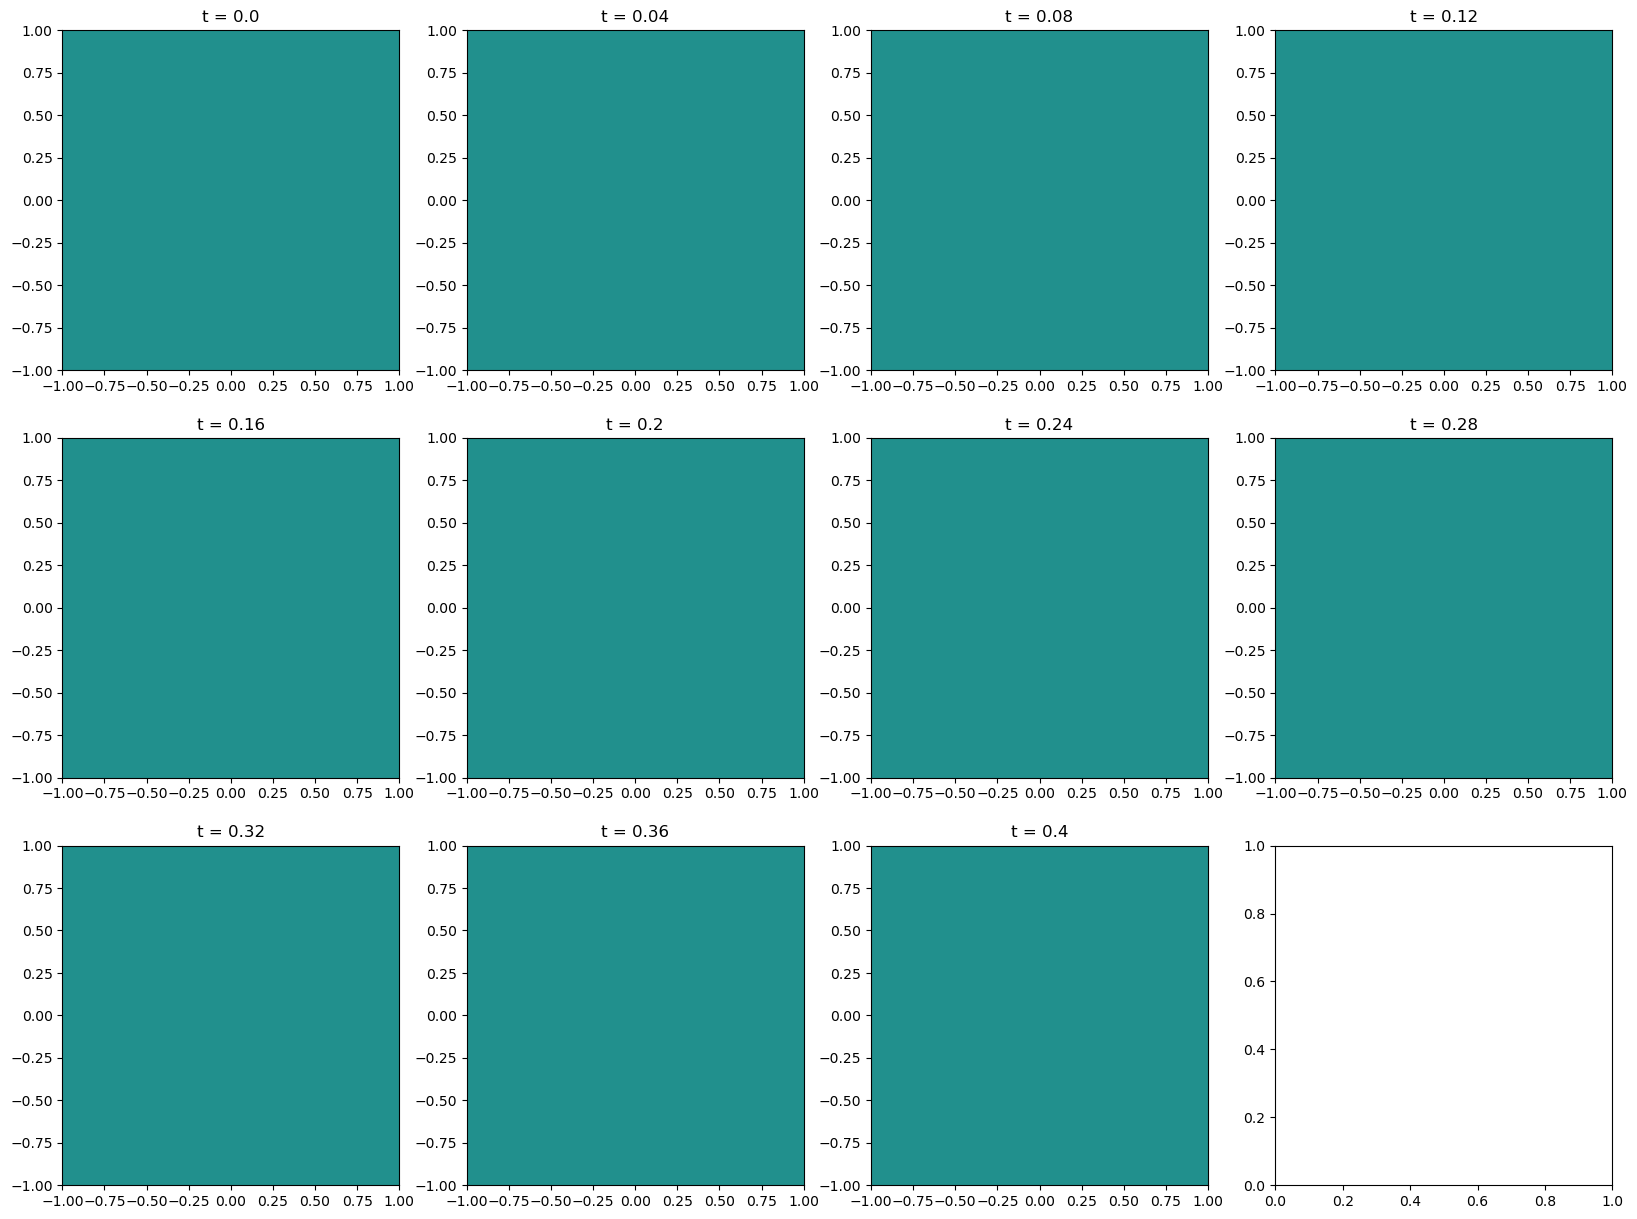

In [36]:
N_test = 1000
x_test = np.linspace(*domain, N_test)
y_test = np.linspace(*domain, N_test)
xy_test = tensor_grid([x_test, y_test])
X, Y = np.meshgrid(x_test, y_test)
x_, y_ = xy_test[:, 0:1], xy_test[:, 1:2]

N_t = 11
t_test = np.linspace(0, T_max, N_t)

import matplotlib.pyplot as plt
from matplotlib.cm import cool
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update(plt.rcParamsDefault)

norm = Normalize(-1.0, 1.0)

N_column = 4
fig, ax = plt.subplots((N_t//N_column)+1, N_column, figsize = (N_column*5, (N_t//N_column)*5+5))
for k in range(N_t):
	i, j = k // N_column, k % N_column
	t_ = t_test[k]*np.ones_like(x_)
	u_pred = direct_model(get_params(opt_state), x_, y_, t_).reshape((N_test, N_test))
	ax[i][j].contourf(X, Y, u_pred, levels = 1000, norm = norm)
	ax[i][j].set_title("t = {}".format(t_test[k]))
fig.colorbar()
plt.show()